# Stack Traces Project (Spark-ML)

## Importing the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import re
from pathlib import Path
from typing import Tuple, List, Optional, Union, Tuple
from pprint import pprint
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec
import string
import seaborn as sns
import datetime
from itertools import permutations
import heapq
import csv
import pickle
import matplotlib.ticker as mtick
import collections
import os
from tabulate import tabulate
from openpyxl import load_workbook

# pd.options.display.max_colwidth = 500
# pd.options.display.max_columns = None
# pd.options.display.max_rows = None
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Setting up the project environment

In [2]:
# .csv configuration
encoding = "utf-8"
delimiter = None
working_directory_path = "../"

## Loading the question dataset

In [3]:
pure_data = working_directory_path + "question_tag.csv"
path = Path(pure_data)

if path.suffix == ".csv":
    df_sotorrent = pd.read_csv(path, encoding=encoding)
else:
    raise ValueError("{data_file_path.suffix} extensions are not supported")

In [4]:
df_sotorrent.shape

(163194, 11)

In [5]:
df_sotorrent['Source'] = 'old'

Update the DB

In [6]:
pure_data = working_directory_path + "proj1_update_qst.csv"
path = Path(pure_data)

if path.suffix == ".csv":
    df_remained = pd.read_csv(path, encoding=encoding)
else:
    raise ValueError("{data_file_path.suffix} extensions are not supported")

In [7]:
df_remained.shape

(49918, 11)

In [8]:
df_remained['source'] = 'new'

Concat two data frames

In [9]:
df = pd.concat([df_sotorrent, df_remained])
df.shape

(213112, 13)

In [10]:
df.drop_duplicates(["Id", "PostTypeId", "AcceptedAnswerId", "ViewCount", "AnswerCount", "CommentCount", "Score", "Title", 'Body', 'Tags'], ignore_index=False, inplace=True)
df = df.reset_index(drop=True)

In [11]:
print("The total number of records (w/o considering specific tag set) :", df.shape[0])

The total number of records (w/o considering specific tag set) : 171114


## Answering the first research question (RQ1)

### Filtering the specific tags

In [12]:
def tag_filter(pref_tags: List, tags: str) -> bool:
    regex = ""
    for tag in pref_tags:
        regex += '(?=.*\\b'+ tag +'([+-]?([0-9]*[.])?[0-9]*)\\b)'
    regex = r"^" + regex + ".*$"
    tags = tags.strip().lower()
    match_result = re.match(regex, tags, re.MULTILINE | re.IGNORECASE)
    if match_result is None:
        return 0
    else:
        return 1

In [13]:
tags = ["spark-ml", "python"]
df['HasPreferableTags'] = df['Tags'].apply(lambda row_tags: tag_filter(tags, row_tags))

In [14]:
df_w_sp_tags = df[df['HasPreferableTags']==True]

In [15]:
df_w_sp_tags = df_w_sp_tags.drop(['HasPreferableTags'], axis='columns')

In [16]:
df_w_sp_tags.shape

(168, 13)

We found there are some duplocated rows in our DB, so we eleminate those based on some columns 

In [17]:
df_w_sp_tags.drop_duplicates(["Id", "PostTypeId", "AcceptedAnswerId", "ViewCount", "AnswerCount", "CommentCount", "Score", "Title"], ignore_index=False, inplace=True)
df_w_sp_tags = df_w_sp_tags.reset_index(drop=True)

In [18]:
df_w_sp_tags.shape

(168, 13)

The new dataset that has a specific tag/s is reduced to:

In [19]:
print("The orginal DB: ", df.shape[0])
print("The new DB (sp): ", df_w_sp_tags.shape[0])
print("The difference is: ", df.shape[0] - df_w_sp_tags.shape[0])

The orginal DB:  171114
The new DB (sp):  168
The difference is:  170946


In [20]:
df_w_sp_tags.head()

,Id,PostTypeId,AcceptedAnswerId,CreationDate,ViewCount,AnswerCount,CommentCount,Score,Title,Body,Tags,Source,source
0,43929708,1,43931068.0,2017-05-12 05:10:08,386,1,0,0,Pyspark Logistic Regression model changing acc...,<p>I built a Pyspark Multinomial Logistic Reg...,<python><pyspark><apache-spark-ml>,old,NaN
1,53154852,1,NaN,2018-11-05 12:53:42,100,0,2,1,Error in MLP Classifier in pyspark fit method,<p>I am using <strong>MultilayerPerceptronClas...,<python><pyspark><apache-spark-ml>,old,NaN
2,50473181,1,50473277.0,2018-05-22 17:12:35,112,1,0,2,PySpark PCA: get number of components from mod...,<p>I have a fit a PCA model in PySpark and I n...,<python><apache-spark><pyspark><apache-spark-ml>,old,NaN
3,49805284,1,NaN,2018-04-12 20:22:00,1612,2,0,3,How to get node information on Spark Decision ...,<p>I'd like to have more detailed information ...,<python><scala><pyspark><apache-spark-mllib><a...,old,NaN
4,32714825,1,NaN,2015-09-22 10:44:13,2079,0,12,6,Custom Transformer in PySpark Pipeline with Cr...,<p>I wrote a custom transformer like it is des...,<python><apache-spark><pyspark><apache-spark-1...,old,NaN


### Extracting the code parts from body

In [21]:
def extract_code_blocks(body: str, _id: int) -> List:
    global index
    # regex = r"<pre><code>((.*?)|(\n)*)*(<\/code><\/pre>|</pre></code>)"
    # regex = r"(<pre>|(<pre((.*?)|(\n)*)*><code>))((.*?)|(\n)*)*(<\/code><\/pre>|</pre></code>|</pre>)"
    regex = r"<pre(><code>|>|(((.*?)|(\n)*)><code>)|((.*?)|(\n)*)>)((.*?)|(\n)*)*(<\/code><\/pre>|</pre></code>|</pre>)"
    matches = re.finditer(regex, body, re.MULTILINE | re.IGNORECASE)
    result = []
    
    try:
        for matchNum, match in enumerate(matches, start=1):
            code = match.group()
            code = re.sub('<pre(><code>|>|(((.*?)|(\n)*)><code>)|((.*?)|(\n)*)>)', '', code)
            code = code.replace("<pre><code>", "")
            code = code.replace("</pre></code>", "")
            code = code.replace("</code></pre>", "")
            result.append(code)
    except:
        print("\n Error(1): ", _id)
        print(body)
        return None
    
    return result

In [22]:
df_w_sp_tags['Code'] = df_w_sp_tags.apply(lambda row: extract_code_blocks(row.Body, row.Id), axis=1)

In [23]:
# print(df_w_tags.iloc[7]['Body'])
# print(type(extract_code_blocks(df_w_tags.iloc[7]['Body'])))
# print(len(extract_code_blocks(df_w_tags.iloc[7]['Body'])))
# print(extract_code_blocks(df_w_tags.iloc[7]['Body'])[0])

Reset the index of dataframe:

In [24]:
df_w_sp_tags = df_w_sp_tags.reset_index(drop=True)

#### Finding the number of questions that have a code or not

In [25]:
count__question_w_code  = 0
count__question_wo_code = 0
count__num_codes = 0

def counting_w_or_wo_code(row_code: List) -> bool:
    global count__question_w_code, count__question_wo_code, count__num_codes
    
    if row_code:
        count__question_w_code = count__question_w_code + 1
        count__num_codes += len(row_code)
        return True
    else:
        count__question_wo_code = count__question_wo_code + 1
        return False

In [26]:
df_w_sp_tags['Has_code'] = df_w_sp_tags['Code'].apply(lambda row_code: counting_w_or_wo_code(row_code))

In [27]:
print(f"We have {df_w_sp_tags.shape[0]} records in our DB, including {count__question_w_code} posts that have code block in themselve and {count__question_wo_code} w/o any code block.")
print(f"We have {count__num_codes} number of code blocks including stacktrace, snippet code, error message.")

We have 168 records in our DB, including 152 posts that have code block in themselve and 16 w/o any code block.
We have 370 number of code blocks including stacktrace, snippet code, error message.


### Define two lists for storing the information of the questions w or w/o Code Block

In [28]:
Question_w_code_info = []
Question_wo_code_info = []

def counting_w_or_wo_code(row_id: int, 
                           row_cr: object, 
                           row_vc: int, 
                           row_ac: int, 
                           row_cc: int, 
                           row_sc: int, 
                           row_ac_an_id: float, 
                           has_code: bool) -> None:
    
    global Question_w_code_info, Question_wo_code_info

    if has_code:
        Question_w_code_info.append((row_id, row_cr, row_vc, row_ac, row_cc, row_sc, row_ac_an_id))

    else:
        Question_wo_code_info.append((row_id, row_cr, row_vc, row_ac, row_cc, row_sc, row_ac_an_id))

In [29]:
_ = df_w_sp_tags.apply(lambda row: counting_w_or_wo_code(row.Id, 
                                                           row.CreationDate, 
                                                           row.ViewCount,
                                                           row.AnswerCount,
                                                           row.CommentCount,
                                                           row.Score,
                                                           row.AcceptedAnswerId,
                                                           row.Has_code), axis=1)

Create dfs based on the two lists, Question_w_code_info and Question_wo_code_info and filled their answers

In [30]:
df_q_w_code_v1 = pd.DataFrame(columns=['First_ans_time', 'First_acc_ans_time', 'Answers'])

df_q_w_code_v1["Q_info"] = Question_w_code_info

df_q_w_code_v1["Q_id"]          = df_q_w_code_v1['Q_info'].apply(lambda q_info: q_info[0])
df_q_w_code_v1["Q_create_time"] = df_q_w_code_v1['Q_info'].apply(lambda q_info: q_info[1])
df_q_w_code_v1["View_count"]    = df_q_w_code_v1['Q_info'].apply(lambda q_info: q_info[2])
df_q_w_code_v1["Answer_count"]  = df_q_w_code_v1['Q_info'].apply(lambda q_info: q_info[3])
df_q_w_code_v1["Comment_count"] = df_q_w_code_v1['Q_info'].apply(lambda q_info: q_info[4])
df_q_w_code_v1["Score"]         = df_q_w_code_v1['Q_info'].apply(lambda q_info: q_info[5])
df_q_w_code_v1["Accepted_Answer_id"] = df_q_w_code_v1['Q_info'].apply(lambda q_info: q_info[6])
df_q_w_code_v1 = df_q_w_code_v1.drop(['Q_info'], axis='columns')
df_q_w_code_v1["Q_create_time"]      = pd.to_datetime(df_q_w_code_v1["Q_create_time"])
df_q_w_code_v1["First_acc_ans_time"] = pd.to_datetime(df_q_w_code_v1["First_acc_ans_time"])
df_q_w_code_v1["First_ans_time"]     = pd.to_datetime(df_q_w_code_v1["First_ans_time"])

In [31]:
# Store them
df_q_w_code_v1["Q_id"].to_csv('../code_output_csv/df_sp_q_w_code.csv', encoding='utf-8')

The below csv file is the result of the top query

In [32]:
pure_data = working_directory_path + "db_results/" + "spark_ans_all.csv"
path = Path(pure_data)

if path.suffix == ".csv":
    df_ans_all = pd.read_csv(path, encoding=encoding)
else:
    raise ValueError("{data_file_path.suffix} extensions are not supported")

In [33]:
pd_tmp_w = pd.merge(df_q_w_code_v1, df_ans_all, how='outer',left_on=['Q_id'], right_on=['ParentId']).reset_index(drop=True)

pd_tmp_w["Answer_tup"] = pd_tmp_w.apply(lambda x: (x.Id, x.CreationDate), axis=1)

pd_tmp_new_w = pd_tmp_w.groupby(["Q_id_x", "Q_create_time", "View_count", "Comment_count", "Score", "Answer_count", "Accepted_Answer_id"], dropna=False)["Answer_tup"].agg(list).reset_index()
pd_tmp_new2_w = pd_tmp_new_w[pd_tmp_new_w.Answer_count != 0].reset_index(drop=True)

In [34]:
def checker_ans_and_ans_tup(q_id: int, row_indx: int, ans_count: int, ans_list: list) -> None:
    if len(ans_list) < ans_count:
        print("Warning!: ", q_id, ans_count, ans_list)

_ = pd_tmp_new2_w.apply(lambda row: checker_ans_and_ans_tup(row.Q_id_x, row.name, row.Answer_count, row.Answer_tup), axis=1)

Warning!:  38384347.0 5.0 [(38385033.0, '2016-07-14 22:09:23'), (55871614.0, '2019-04-26 16:26:16'), (58736226.0, '2019-11-06 18:13:55'), (63038648.0, '2020-07-22 16:12:47')]
Warning!:  48433197.0 2.0 [(nan, nan)]


In [35]:
pd_tmp_new2_w.insert(len(pd_tmp_new2_w.columns), 'First_ans_time', np.nan)
pd_tmp_new2_w.insert(len(pd_tmp_new2_w.columns), 'First_acc_ans_time', np.nan)
pd_tmp_new3_w = pd_tmp_new2_w.copy()

In [36]:
for index1, row_status in pd_tmp_new3_w.iterrows():   
    flag = 0
    fr_time = pd.to_datetime(datetime.datetime.now())
    acc_time = pd.to_datetime(datetime.datetime.now())
        
    if not row_status["Answer_tup"]:
        pd_tmp_new3_w.at[index1,'First_ans_time'] = np.nan
        pd_tmp_new3_w.at[index1,'First_acc_ans_time'] = np.nan
        continue

    for answer in row_status["Answer_tup"]:
        
        anwer_time = pd.to_datetime(answer[1])
        
        if flag == 0:
            fr_time = anwer_time
            flag = 1
        
        if fr_time > anwer_time:
            fr_time = anwer_time
        
        if row_status["Accepted_Answer_id"] == answer[0]:
            acc_time = anwer_time

    pd_tmp_new3_w.at[index1,'First_ans_time'] = fr_time
        
    if pd.isna(row_status["Accepted_Answer_id"]):
        acc_time = np.nan
    
    pd_tmp_new3_w.at[index1,'First_acc_ans_time'] = acc_time

pd_tmp_new3_w["Duration_ans"] = pd_tmp_new3_w.apply(lambda row: (row.First_ans_time-row.Q_create_time).total_seconds()/3600 if not pd.isna(row.First_ans_time) else np.nan, axis=1)
pd_tmp_new3_w["Duration_acc_ans"] = pd_tmp_new3_w.apply(lambda row: (row.First_acc_ans_time-row.Q_create_time).total_seconds()/3600 if not pd.isna(row.First_acc_ans_time) else np.nan, axis=1)

We did the same behaviour for the Question_wo_code_info list.

In [37]:
df_q_wo_code_v1 = pd.DataFrame(columns=['First_ans_time', 'First_acc_ans_time', 'Answers'])

df_q_wo_code_v1["Q_info"] = Question_wo_code_info

df_q_wo_code_v1["Q_id"]          = df_q_wo_code_v1['Q_info'].apply(lambda q_info: q_info[0])
df_q_wo_code_v1["Q_create_time"] = df_q_wo_code_v1['Q_info'].apply(lambda q_info: q_info[1])
df_q_wo_code_v1["View_count"]    = df_q_wo_code_v1['Q_info'].apply(lambda q_info: q_info[2])
df_q_wo_code_v1["Answer_count"]  = df_q_wo_code_v1['Q_info'].apply(lambda q_info: q_info[3])
df_q_wo_code_v1["Comment_count"] = df_q_wo_code_v1['Q_info'].apply(lambda q_info: q_info[4])
df_q_wo_code_v1["Score"]         = df_q_wo_code_v1['Q_info'].apply(lambda q_info: q_info[5])
df_q_wo_code_v1["Accepted_Answer_id"] = df_q_wo_code_v1['Q_info'].apply(lambda q_info: q_info[6])
df_q_wo_code_v1 = df_q_wo_code_v1.drop(['Q_info'], axis='columns')
df_q_wo_code_v1["Q_create_time"] = pd.to_datetime(df_q_wo_code_v1["Q_create_time"])
df_q_wo_code_v1["First_acc_ans_time"] = pd.to_datetime(df_q_wo_code_v1["First_acc_ans_time"])
df_q_wo_code_v1["First_ans_time"]     = pd.to_datetime(df_q_wo_code_v1["First_ans_time"])

In [38]:
# Store
df_q_wo_code_v1["Q_id"].to_csv('../code_output_csv/df_sp_q_wo_code.csv', encoding='utf-8')

We used the all answers csv file again, again. 

In [39]:
pure_data = working_directory_path + "db_results/" + "spark_ans_all.csv"
path = Path(pure_data)

if path.suffix == ".csv":
    df_night_wo = pd.read_csv(path, encoding=encoding)
else:
    raise ValueError("{data_file_path.suffix} extensions are not supported")

In [40]:
df_night_wo = df_night_wo.reset_index(drop=True)
df_q_wo_code_v1['Answers'] = df_q_wo_code_v1.apply(lambda x: [], axis=1)

pd_tmp_wo = pd.merge(df_q_wo_code_v1, df_night_wo, how='left',left_on=['Q_id'],right_on=['ParentId']).reset_index(drop=True)

pd_tmp_wo["Answer_tup"] = pd_tmp_wo.apply(lambda x: (x.Id, x.CreationDate), axis=1)
pd_tmp_new_wo = pd_tmp_wo.groupby(["Q_id_x", "Q_create_time", "View_count", "Comment_count", "Score", "Answer_count", "Accepted_Answer_id"], dropna=False)["Answer_tup"].agg(list).reset_index()
pd_tmp_new2_wo = pd_tmp_new_wo[pd_tmp_new_wo.Answer_count != 0].reset_index(drop=True)

In [41]:
_ = pd_tmp_new2_wo.apply(lambda row: checker_ans_and_ans_tup(row.Q_id_x, row.name, row.Answer_count, row.Answer_tup), axis=1)

In [42]:
pd_tmp_new2_wo.insert(len(pd_tmp_new2_wo.columns), 'First_ans_time', np.nan)
pd_tmp_new2_wo.insert(len(pd_tmp_new2_wo.columns), 'First_acc_ans_time', np.nan)
pd_tmp_new3_wo = pd_tmp_new2_wo.copy()

In [43]:
for index1, row_status in pd_tmp_new3_wo.iterrows():   
    flag = 0
    fr_time = pd.to_datetime(datetime.datetime.now())
    acc_time = pd.to_datetime(datetime.datetime.now())
        
    if not row_status["Answer_tup"]:
        pd_tmp_new3_wo.at[index1,'First_ans_time'] = np.nan
        pd_tmp_new3_wo.at[index1,'First_acc_ans_time'] = np.nan
        continue

    for answer in row_status["Answer_tup"]:
        
        anwer_time = pd.to_datetime(answer[1])
        
        if flag == 0:
            fr_time = anwer_time
            flag = 1
        
        if fr_time > anwer_time:
            fr_time = anwer_time
        
        if row_status["Accepted_Answer_id"] == answer[0]:
            acc_time = anwer_time

    pd_tmp_new3_wo.at[index1,'First_ans_time'] = fr_time
        
    if pd.isna(row_status["Accepted_Answer_id"]):
        acc_time = np.nan
    
    pd_tmp_new3_wo.at[index1,'First_acc_ans_time'] = acc_time

In [44]:
pd_tmp_new3_wo["Duration_ans"] = pd_tmp_new3_wo.apply(lambda row: (row.First_ans_time-row.Q_create_time).total_seconds()/3600 if not pd.isna(row.First_ans_time) else np.nan, axis=1)
pd_tmp_new3_wo["Duration_acc_ans"] = pd_tmp_new3_wo.apply(lambda row: (row.First_acc_ans_time-row.Q_create_time).total_seconds()/3600 if not pd.isna(row.First_acc_ans_time) else np.nan, axis=1)

In [45]:
# Store
pd_tmp_new3_w.to_csv('./CSV_data/plt_sp_q_w_code.csv', encoding='utf-8')
pd_tmp_new3_wo.to_csv('./CSV_data/plt_sp_q_wo_code.csv', encoding='utf-8')

### Extracting the text parts from body

In [46]:
def extract_text_blocks(i: int, body: str) -> Optional[List]:
    # It's bug
    if i in [10005, 14212, 21959, 26677, 53279, 22356]: 
        body = body + "</p>"

    regex = r"(<p>((.*?)|(\n)*)*<\/p>)|(<ul>((.*?)|(\n)*)*<\/ul>)|(<ol>((.*?)|(\n)*)*<\/ol>)"
    matches = re.finditer(regex, body, re.MULTILINE | re.IGNORECASE)
    result = []
    
    if i in [18397]:
        return result

    try:
        for matchNum, match in enumerate(matches, start=1):
            text = match.group()
            text = text.replace("<p>", "")
            text = text.replace("<strong>", "")
            text = text.replace("<br>", "")
            text = text.replace("<ol>", "")
            text = text.replace("<ul>", "")
            text = text.replace("<li>", "")
            text = text.replace("</p>", "")
            text = text.replace("</strong>", "")
            text = text.replace("</ol>", "")
            text = text.replace("</ul>", "")
            text = text.replace("</li>", "")
            result.append(text)
        return result
    except:
        print("Error(1): ", i)
        print(body)
        return None

In [47]:
df_w_sp_tags['Text'] = df_w_sp_tags.apply(lambda row: extract_text_blocks(row.name, row.Body), axis=1)

#### Finding the number of body words

In [48]:
def find_q_text_words(text_list: List) -> int:
    word_count = 0
    for text in text_list:
        word_count += sum([i.strip(string.punctuation).isalpha() for i in text.split()])
    return word_count

In [49]:
df_w_sp_tags['Q_text_words_num'] = df_w_sp_tags["Text"].apply(lambda text_list: find_q_text_words(text_list))

Save the dataframe as csv format

In [50]:
# df_w_Tens_tags.to_csv('./amin_result_v1.csv', encoding='utf-8')

### Find the Regular Expressions for Unix and Windows base Pathnames

#### 1) Absolute and Relative Pathnames in UNIX OS

Stack/trace example: https://stackoverflow.com/questions/37337728/tensorflow-internalerror-blas-sgemm-launch-failed

Find the restrictions and limitations related to the Unix pathnames: https://www.cyberciti.biz/faq/linuxunix-rules-for-naming-file-and-directory-names/

Online regular expression environment for testing: https://regex101.com/r/ZyEx5u/4

> Regular Expression: "[^\n\&\:\|\>\<\/\ \"\;\&]*(\/[^\n\&\:\|\>\<\/]+)+\/([^\n\&\:\|\>\<\/]+)(\.pyc|\.py)"

#### 1) Pathnames in Windows OS

Stack/trace example: https://stackoverflow.com/questions/49434031/tensorflow-on-windows-cpu-version-importerror-no-module-named-pywrap-tensorf

Find the restrictions and limitations related to the Windows pathnames: <br /> 
https://docs.microsoft.com/en-us/dotnet/standard/io/file-path-formats <br />
https://docs.microsoft.com/en-us/windows/win32/fileio/naming-a-file

Online regular expression environment for testing: https://regex101.com/r/L6xmCa/1 , https://regex101.com/r/wz1WqW/1

> Regular Expression: "[a-zA-Z]:\\?([^\<\>\:\"\\\/\/\|\?\*\n]+\\)+([^\<\>\:\"\\\/\/\|\?\*\n]+)(\.pyc|\.py)"

In [51]:
def extract_pathnames_from_code_column(code_sec: List, _id: int) -> Tuple[str, List]: 
    try:
        result_post_file_names = []
        OS_flag = None
        error_index = None
        error_code = None
        regex_unix    = r"[^\n\&\:\|\>\<\/\ \"\;\&]*(\/[^\n\&\:\|\>\<\/]+)+\/([^\n\&\:\|\>\<\/\\]+)(\.pyc|\.py)[^\d\n]+(\d*)\W*in\s\W*\d*([a-zA-Z_$][a-zA-Z_$0-9]*)"
        regex_windows = r"(([a-zA-Z]:)|\~)\\?\/?([^\<\>\:\"\\\|\?\*\n]+\\)+([^\<\>\:\"\\\/\/\|\?\*\n]+)(\.pyc|\.py)[^\d\n]+(\d*)\W*in\W+([a-zA-Z_$][a-zA-Z_$0-9]*)"
        
        for idx, code in enumerate(code_sec):
            pattern_unix  = re.compile(regex_unix)
            pattern_windows  = re.compile(regex_windows)
            if pattern_unix.search(code):
                OS_flag = "unix"
                break
            elif pattern_windows.search(code):
                OS_flag = "windows"
                break
                
        if OS_flag == "unix":
            for idx, code in enumerate(code_sec):
                error_index = idx
                code = code.replace("\\n", "\n")
                code = code.replace('&lt;', '<')
                code = code.replace('&gt;', '>')
                code = code.replace('&quot;', '"')
                error_code = code
                matches = re.finditer(regex_unix, code, re.MULTILINE)
                file_names_for_each_code_part = []
                
                for matchNum, match in enumerate(matches, start=1):
                    file_names_for_each_code_part.append((match.groups()[1].strip(), match.groups()[4].strip()))
#                     file_names_for_each_code_part.append(match.groups()[1].strip())
                    # print ("Match {matchNum} was found at {start}-{end}: {match}".format(matchNum = matchNum, start = match.start(), end = match.end(), match = match.group()))
                    # for groupNum in range(0, len(match.groups())):
                        # groupNum = groupNum + 1
                        # print ("Group {groupNum} found at {start}-{end}: {group}".format(groupNum = groupNum, start = match.start(groupNum), end = match.end(groupNum), group = match.group(groupNum)))
#                 print(file_names_for_each_code_part)
#                 file_names_for_each_code_part = list(set(file_names_for_each_code_part))            # Create a unique list
#                 print(file_names_for_each_code_part)
                
                if file_names_for_each_code_part:                                                   # Ignore the empty list
                    result_post_file_names.append(file_names_for_each_code_part)
                    
        elif OS_flag == "windows":
            for idx, code in enumerate(code_sec):
                code = code.replace('&lt;', '<')
                code = code.replace('&gt;', '>')
                code = code.replace('&quot;', '"')
                error_code = code
                matches = re.finditer(regex_windows, code, re.MULTILINE)                            
                file_names_for_each_code_part = []

                for matchNum, match in enumerate(matches, start=1):
                    file_names_for_each_code_part.append((match.groups()[3].strip(), match.groups()[6].strip()))
#                     file_names_for_each_code_part.append(match.groups()[1].strip())
                    # print ("Match {matchNum} was found at {start}-{end}: {match}".format(matchNum = matchNum, start = match.start(), end = match.end(), match = match.group()))
                    # for groupNum in range(0, len(match.groups())):
                        # groupNum = groupNum + 1
                        # print ("Group {groupNum} found at {start}-{end}: {group}".format(groupNum = groupNum, start = match.start(groupNum), end = match.end(groupNum), group = match.group(groupNum)))
#                 file_names_for_each_code_part = [s.strip() for s in file_names_for_each_code_part]  # Strip the list
#                 file_names_for_each_code_part = list(set(file_names_for_each_code_part))            # create a unique list
                if file_names_for_each_code_part:                                                     # Ignore the empty list
                    result_post_file_names.append(file_names_for_each_code_part)
            
    except:
        print("\n Error Id:", _id, " Error index:", error_index, "\n")
        print(error_code)
        return None, None

    return OS_flag, result_post_file_names

In [52]:
# Example for Unix path
# https://stackoverflow.com/questions/51839415/tensorflow-valueerror-rank-mismatch
# df_w_sp_tags.iloc[9][:]
extract_pathnames_from_code_column(df_w_sp_tags["Code"][51], 0)

(None, [])

In [53]:
# Example for Windows path
# df_w_sp_tags['Code'] = df_w_sp_tags['Body'].apply(lambda row_body: extract_code_blocks(row_body))
# print(df_w_sp_tags["Code"][9])
# extract_pathnames_from_code_column(df_w_sp_tags["Code"][84])
# extract_pathnames_from_code_column(df_w_sp_tags["Code"][606])

In [54]:
# df_w_sp_tags["Body"][606]

In [55]:
df_w_sp_tags['Bugy_py_files'] = df_w_sp_tags.apply(lambda row: extract_pathnames_from_code_column(row.Code, row.Id), axis=1)

Save the dataframe as csv format

In [56]:
# df_w_sp_tags.loc[df_w_PT_tags['Id'] == 46509039]

In [57]:
# df_w_sp_tags[["Title", "Code", "Bugy_py_files"]].head(100)
# df_w_sp_tags.to_csv('./sp_Code_bug.csv', sep='\n', encoding='utf-8')
# df_w_sp_tags['Bugy_py_files'].to_csv('./sp_bugy_tuples.csv', encoding='utf-8')

In [58]:
def create_has_trace_col(cal_tuple) -> bool:
    if cal_tuple[0] == "windows" or cal_tuple[0] == "unix":
        return True
    elif cal_tuple[0] is None:
        return False
    else:
        print("Error!")

In [59]:
df_w_sp_tags['Has_trace'] = df_w_sp_tags['Bugy_py_files'].apply(lambda cell_tuple: create_has_trace_col(cell_tuple))

#### Finding the number and type of LOC in the body of post:

For example how many pairs did you find in a post and defining the OS of that stack trace

In [60]:
def finding_line_of_code(code_list: List) -> Tuple[int, int, int]:
    line_count_trace_win   = 0
    line_count_trace_unix  = 0
    line_count_simple_code = 0
    
    for code in code_list:
        regex_unix    = r"[^\n\&\:\|\>\<\/\ \"\;\&]*(\/[^\n\&\:\|\>\<\/]+)+\/([^\n\&\:\|\>\<\/\\]+)(\.pyc|\.py)[^\d\n]+(\d*)\W*in\s\W*\d*([a-zA-Z_$][a-zA-Z_$0-9]*)"
        regex_windows = r"(([a-zA-Z]:)|\~)\\?\/?([^\<\>\:\"\\\|\?\*\n]+\\)+([^\<\>\:\"\\\/\/\|\?\*\n]+)(\.pyc|\.py)[^\d\n]+(\d*)\W*in\W+([a-zA-Z_$][a-zA-Z_$0-9]*)"
        # regex_unix    = r"[^\n\&\:\|\>\<\/\ \"\;\&]*(\/[^\n\&\:\|\>\<\/]+)+\/([^\n\&\:\|\>\<\/]+)(\.pyc|\.py)[^\d\n]+(\d*)\W*in\W+([a-zA-Z_$][a-zA-Z_$0-9]*)" version 2
        # regex_unix    = r"[^\n\&\:\|\>\<\/\ \"\;\&]*(\/[^\n\&\:\|\>\<\/]+)+\/([^\n\&\:\|\>\<\/]+)(\.pyc|\.py)[^\d\n]+(\d+)\W*in\W*([a-zA-Z_$][a-zA-Z_$0-9]*)" version 1
        # regex_windows = r"[a-zA-Z]:\\?([^\<\>\:\"\\\/\/\|\?\*\n]+\\)+([^\<\>\:\"\\\/\/\|\?\*\n]+)(\.pyc|\.py)[^\d\n]+(\d+)\W*in\W*([a-zA-Z_$][a-zA-Z_$0-9]*)"
        pattern_unix  = re.compile(regex_unix)
        pattern_windows = re.compile(regex_windows)
        if pattern_unix.search(code):
            OS_flag = "unix"
        elif pattern_windows.search(code):
            OS_flag = "windows"
        else:
            OS_flag = "nothing"
            
        code_wo_empty_line = os.linesep.join([s for s in code.splitlines() if s])
            
        if OS_flag == "unix":
            line_count_trace_unix += len(code_wo_empty_line.splitlines())
        elif OS_flag == "windows":
            line_count_trace_win += len(code_wo_empty_line.splitlines())
        elif OS_flag == "nothing":
            line_count_simple_code += len(code_wo_empty_line.splitlines()) 
        else:
            print("Error!")

    return (line_count_trace_unix, line_count_trace_win, line_count_simple_code)

In [61]:
finding_line_of_code(df_w_sp_tags.loc[19, 'Code'])

(0, 0, 11)

In [62]:
df_w_sp_tags['Line_code_u_w_s'] = df_w_sp_tags['Code'].apply(lambda code_list: finding_line_of_code(code_list))

In [63]:
df_w_sp_tags['Line_code_uix'] = df_w_sp_tags['Line_code_u_w_s'].apply(lambda loc_tuple: loc_tuple[0])

In [64]:
df_w_sp_tags['Line_code_win'] = df_w_sp_tags['Line_code_u_w_s'].apply(lambda loc_tuple: loc_tuple[1])

In [65]:
# Has a code (Python code) inside the post
df_w_sp_tags['Line_code_simple_code'] = df_w_sp_tags['Line_code_u_w_s'].apply(lambda loc_tuple: loc_tuple[2])

In [66]:
df_w_sp_tags[['Id', 'Q_text_words_num', 'Has_trace', 'Line_code_u_w_s']].head(5)

,Id,Q_text_words_num,Has_trace,Line_code_u_w_s
0,43929708,83,False,"(0, 0, 8)"
1,53154852,66,False,"(0, 0, 33)"
2,50473181,46,False,"(0, 0, 7)"
3,49805284,70,False,"(0, 0, 5)"
4,32714825,110,True,"(59, 0, 60)"


In [67]:
df_w_sp_tags.head(1)

,Id,PostTypeId,AcceptedAnswerId,CreationDate,ViewCount,AnswerCount,CommentCount,Score,Title,Body,Tags,Source,source,Code,Has_code,Text,Q_text_words_num,Bugy_py_files,Has_trace,Line_code_u_w_s,Line_code_uix,Line_code_win,Line_code_simple_code
0,43929708,1,43931068.0,2017-05-12 05:10:08,386,1,0,0,Pyspark Logistic Regression model changing acc...,<p>I built a Pyspark Multinomial Logistic Reg...,<python><pyspark><apache-spark-ml>,old,NaN,"[temp_path = pjoin(""/home/maffsojah/Projects/H...",True,[I built a Pyspark Multinomial Logistic Regre...,83,"(None, [])",False,"(0, 0, 8)",0,0,8


#### Question Post's Length (body of the post): Defining the lists for plotting their comparisons

In [68]:
list_num_words_w_tra  = []
list_num_words_wo_tra = []

for index1, row in df_w_sp_tags.iterrows():
    if row.Has_trace is True:
        list_num_words_w_tra.append(row.Q_text_words_num)
    elif row.Has_trace is False:
        list_num_words_wo_tra.append(row.Q_text_words_num)
    else:
        print("Error!")

#### OS Stack Traces: Defining the number of stack straces the belongs to the Unix or Windows OS

In [69]:
counter_win  = 0
counter_unix = 0
# dim_win  = []
# dim_unix = []

for tp in df_w_sp_tags["Bugy_py_files"]:
    if tp[0] == "windows":
        counter_win += 1
#         np_array = np.array(tuple[1], dtype=object)
#         dim_win.append(np_array.shape)
        
    elif tp[0] == "unix":
        counter_unix += 1
#         np_array = np.array(tuple[1], dtype=object)
#         dim_unix.append(np_array.shape)

print(f"We found the {counter_win} of stackoverflow's posts that belong to the Windows OS.")
print(f"We found the {counter_unix} of stackoverflow's posts that belong to the Unix OS.")
# print("The dimensions of Windows labels is: ", set(dim_win))
# print("The dimensions of Unix labels is: ", set(dim_unix))

We found the 1 of stackoverflow's posts that belong to the Windows OS.
We found the 18 of stackoverflow's posts that belong to the Unix OS.


In [70]:
df_w_sp_tags.dtypes

Id                         int64
PostTypeId                 int64
AcceptedAnswerId         float64
CreationDate              object
ViewCount                  int64
AnswerCount                int64
CommentCount               int64
Score                      int64
Title                     object
Body                      object
Tags                      object
Source                    object
source                    object
Code                      object
Has_code                    bool
Text                      object
Q_text_words_num           int64
Bugy_py_files             object
Has_trace                   bool
Line_code_u_w_s           object
Line_code_uix              int64
Line_code_win              int64
Line_code_simple_code      int64
dtype: object

#### Define two lists for storing the information of the questions w or w/o stack traces

In [71]:
count_w_t  = 0
count_wo_t = 0
count_win  = 0
count_unix = 0

Question_with_trace_info = []
Question_with_wo_trace_info = []

def counting_w_or_wo_trace(row_id: int, 
                           row_cr: object, 
                           row_vc: int, 
                           row_ac: int, 
                           row_cc: int, 
                           row_sc: int, 
                           row_ac_an_id: float, 
                           row_t: object, 
                           has_code: bool) -> None:
    
    global count_w_t, count_wo_t, count_win, count_unix, Question_with_trace_info, Question_with_wo_trace_info

    if has_code:
        if row_t[0] is not None:
            count_w_t = count_w_t + 1
            Question_with_trace_info.append((row_id, row_cr, row_vc, row_ac, row_cc, row_sc, row_ac_an_id))
            
            if row_t[0] == 'unix':
                count_unix = count_unix + 1
            else:
                count_win = count_win + 1
        else:
            count_wo_t = count_wo_t + 1
            Question_with_wo_trace_info.append((row_id, row_cr, row_vc, row_ac, row_cc, row_sc, row_ac_an_id))

In [72]:
_ = df_w_sp_tags.apply(lambda row: counting_w_or_wo_trace(row.Id, 
                                                               row.CreationDate, 
                                                               row.ViewCount,
                                                               row.AnswerCount,
                                                               row.CommentCount,
                                                               row.Score,
                                                               row.AcceptedAnswerId,
                                                               row.Bugy_py_files, 
                                                               row.Has_code), axis=1)

#### Creating a string matrix of pairs

https://stackoverflow.com/questions/32037893/numpy-fix-array-with-rows-of-different-lengths-by-filling-the-empty-elements-wi

In [73]:
def numpy_fillna(data: List) -> np.ndarray:
    # Get lengths of each row of data
    lens = np.array([len(i) for i in data])

    # Mask of valid places in each row
    mask = np.arange(lens.max()) < lens[:, None]

    # Setup output array and put elements from data into masked positions
    out = np.zeros(mask.shape, dtype='object')
    out[mask] = np.concatenate(data)
    
    return out

In [74]:
_2D_array_with_str = []

# The below list store the post Id for each instances (or row in _2D_array). 
# We have to mention that the index of _2D_array and _Id_array helps us to find the id pattern quickly.
_Id_array = []

for index1, row in df_w_sp_tags.iterrows():
    row_tuple = row.Bugy_py_files
    row_id = row.Id
    
    # row: (some rows have multiple patterns)
    # ('unix', [[('estimator', 'train'), ('estimator', '_train_model'), 
    #            ('estimator', '_train_model_default'), ('estimator', '_call_model_fn'), ('nn_ops', 'sparse_softmax_cross_entropy_with_logits')]])
    
    if row_tuple[0] is None: continue
    
    for element in row_tuple[1]:
        _Id_array.append(row_id)
        element_tmp = element[:]
        _2D_array_with_str.append(element_tmp)

# _2D_array_pad = numpy_fillna(_2D_array)

#### Creating a numerical matrix

https://www.geeksforgeeks.org/python-pandas-factorize/

##### Creating a dictionary based on pairs and assigning a unique number to that

In [75]:
# dict pair : int

dic = {} 
specific_val = 1
for row in _2D_array_with_str:
    for element in row:
        if element not in dic:
            dic[element] = specific_val
            specific_val += 1

In [76]:
print("The number of unique pairs is: ", max(dic.values()))

The number of unique pairs is:  38


##### Converting strings on the _2D_array into numbers 

In [77]:
# _2D_array_with_str

In [78]:
# _2D_array = list()
# _2D_array_str = _2D_array_with_str.copy()
# _2D_array = _2D_array_with_str[:]
_2D_array = _2D_array_with_str[:]

In [79]:
for i, row in enumerate(_2D_array):
    for j in range(len(row)):
        _2D_array[i][j] = dic[_2D_array[i][j]]

In [80]:
_2D_array_with_str

[[1, 2, 1, 3, 1, 4, 5, 6, 7],
 [8, 9, 10, 11, 12, 8, 9, 10, 11, 12],
 [13, 14, 15, 6, 16, 7, 8, 9, 10, 17, 18, 19, 18, 20, 21],
 [1, 2, 1, 4, 5, 6, 16, 7],
 [22, 23],
 [24, 2, 25],
 [26, 6, 7],
 [27, 28, 6, 16],
 [29, 14, 15, 6, 16, 7],
 [26, 6, 16, 7],
 [30, 31, 6, 16, 7],
 [23],
 [26, 6, 16, 7],
 [24, 4, 5, 6, 16, 7],
 [32],
 [33, 33, 6, 16, 7],
 [34, 35, 15, 36, 16],
 [37],
 [38],
 [26, 6, 16, 7]]

In [81]:
_2D_array[0:10]

[[1, 2, 1, 3, 1, 4, 5, 6, 7],
 [8, 9, 10, 11, 12, 8, 9, 10, 11, 12],
 [13, 14, 15, 6, 16, 7, 8, 9, 10, 17, 18, 19, 18, 20, 21],
 [1, 2, 1, 4, 5, 6, 16, 7],
 [22, 23],
 [24, 2, 25],
 [26, 6, 7],
 [27, 28, 6, 16],
 [29, 14, 15, 6, 16, 7],
 [26, 6, 16, 7]]

In [82]:
# uniqe_dic int : pair
uniqe_dic = dict([(value, key) for key, value in dic.items()])

By the below function we deleted duplicated rows in 2d_array:

In [83]:
def find_2d_array_dup(_2d_array: list) -> Tuple[int, list]:
    
    dup_count = 0
    _2d_array_tmp = _2d_array.copy()
    _2d_array_tmp_next = []
    
    idx = 0
    while idx != len(_2d_array_tmp):
        
        for indx_previous in range(0, idx+1):
            _2d_array_tmp_next.append(_2d_array_tmp[indx_previous])
        
        for indx_next in range(idx+1, len(_2d_array_tmp)):
#             print(idx, indx_next)
#             print(_2d_array_tmp)
#             print(_2d_array_tmp_next)

            if _2d_array_tmp[idx] == _2d_array_tmp[indx_next]:
                dup_count += 1
            else:
                _2d_array_tmp_next.append(_2d_array_tmp[indx_next])
#         print(_2d_array_tmp_next)
#         print(len(_2d_array_tmp_next))
#         break
        _2d_array_tmp = _2d_array_tmp_next
        _2d_array_tmp_next = []
        idx += 1
    
    return dup_count, _2d_array_tmp

In [84]:
# duplication_row, _2D_array_new = find_2d_array_dup(_2D_array)

In [85]:
# print(f"We decresed the number of patterns from {len(_2D_array)} to {len(_2D_array_new)}.")

## Answering the second research question (RQ2): Finding Patterns

## Contiguous Sequential Pattern Mining

https://www.cc.gatech.edu/~hic/CS7616/pdf/lecture13.pdf

### Approach (1):

The shortest yet efficient implementation of the famous frequent sequential pattern mining algorithm PrefixSpan, the famous frequent closed sequential pattern mining algorithm BIDE (in closed.py), and the frequent generator sequential pattern mining algorithm FEAT (in generator.py), as a unified and holistic algorithm framework.

https://github.com/chuanconggao/PrefixSpan-py

In [86]:
# !pip3 install -U prefixspan

In [87]:
# from prefixspan import PrefixSpan

In [88]:
# ps = PrefixSpan(_2D_array_pad)

In [89]:
# k = ps.frequent(5)

In [90]:
# file = open("/home-students/amghad/sample.txt", "w")
# str_list = repr(k)
# file.write(str_list)
# file.close()

### Approach (2): 

pymining is a small collection of data mining algorithms implemented in Python. I did not design any of the algorithms, but I use them in my own research so I thought other developers might be interested to use them as well.

https://github.com/bartdag/pymining

### Approach (3): By this approach we simply check all possible status for each row (or pattern)

We want to create a dict based on the vectors on the numerical matrix.

By the below function, we tried to find and search the patterns for each vector based on the window_size

0: The index of vector <br>
list: Contains tuples with different windows_size

In [91]:
def append_to_dicc_new(dicc: dict, vec_id: int, list_: list) -> dict:
    if vec_id not in dicc:
        # key not exist
        dicc[vec_id] = list_
    else:
        # key exist
        for tuple_ in list_:
            for item in dicc[vec_id]:
                if item[0] == tuple_[0]:
                    item[1].append(tuple_[1][0])
                    break
    return dicc

The "low" parameter can help us control the lower bound of the window_size.

In [92]:
low = 0    # <~~~~~~~ define the lower bound threshold
up = len(uniqe_dic)
dicc = {}     

for i_v, vector in enumerate(_2D_array):    
    for index, element in enumerate(vector):
        list_ = []
        for wind_size in range(low, len(vector)+1-index):
            list_.append((wind_size, [(*vector[index:index+wind_size], )]))
        dicc = append_to_dicc_new(dicc, i_v, list_)    

In [93]:
_2D_array

[[1, 2, 1, 3, 1, 4, 5, 6, 7],
 [8, 9, 10, 11, 12, 8, 9, 10, 11, 12],
 [13, 14, 15, 6, 16, 7, 8, 9, 10, 17, 18, 19, 18, 20, 21],
 [1, 2, 1, 4, 5, 6, 16, 7],
 [22, 23],
 [24, 2, 25],
 [26, 6, 7],
 [27, 28, 6, 16],
 [29, 14, 15, 6, 16, 7],
 [26, 6, 16, 7],
 [30, 31, 6, 16, 7],
 [23],
 [26, 6, 16, 7],
 [24, 4, 5, 6, 16, 7],
 [32],
 [33, 33, 6, 16, 7],
 [34, 35, 15, 36, 16],
 [37],
 [38],
 [26, 6, 16, 7]]

In [94]:
dicc.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

In [95]:
def remove_duplication(dup_list: list) -> list:
    final_list = []
    for item in dup_list:
        if item not in final_list:
            final_list.append(item)
        else:
            indx = final_list.index(item)
            counter = final_list[indx][0] + 1
            pair = final_list[indx][1]
            final_list.remove(item)
            final_list.append((counter, pair))
    
    return final_list

dic_count is a dictionary that key is window_size, and value is a list that contains tuples. Each tuple shows a pair and the number of pair's iteration on the matrix.

In [96]:
dic_count = {}

for vec_i, list_tuples in dicc.items():
#     print(vec_i, list_tuples,"\n")
    for tuples_ in list_tuples:
#         print(tuples_)
        
        if tuples_[0] not in dic_count:
            lst_ = [(1, tuple_) for tuple_ in tuples_[1]] 
            
            if len(lst_) != len(set(lst_)):
                lst_ = remove_duplication(lst_)
            
            dic_count[tuples_[0]] = lst_  
        else:
            #(2, [(1, 3), (1, 4), (3, 4), (4, 5), (5, 1)]
            #break
            for tuple_ in tuples_[1]:
                flag = 0 
                for item in dic_count[tuples_[0]]:
                    if item[1] == tuple_:
                        counter = item[0] + 1
                        dic_count[tuples_[0]].remove(item)
                        dic_count[tuples_[0]].append((counter, item[1]))
                        flag = 1
                        break
                # tuple is new
                if flag == 0:
                    dic_count[tuples_[0]].append((1, tuple_))
#                 else: 
#                     print("Error100")

dic_count is a dictionary that key is window_size, and value is a list that contains tuples. Each tuple shows a pair and the number of pair's iteration on the matrix.

For each window_size we count the number of patterns that we found

In [97]:
dic_count.pop(0)

[(19, ()), (18, ()), (20, ()), (20, ()), (20, ())]

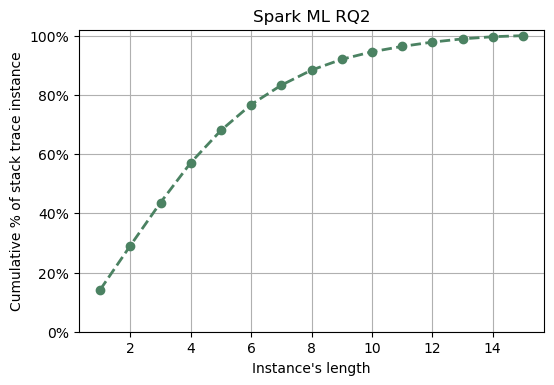

In [98]:
inst_length = dic_count.keys()
inst_count = [len(value) for key, value in dic_count.items()]
comulative_inst_count = np.cumsum(inst_count)

per_comulative_inst_count = []
for element in comulative_inst_count:
    per_comulative_inst_count.append((element*100)/comulative_inst_count[-1])

fig = plt.figure(figsize=(6, 4), dpi=100)
ax1 = fig.add_subplot(111)

ax1.plot(inst_length, per_comulative_inst_count, '--o', color='#4b8262', linewidth=2)
plt.xlabel('Instance\'s length')
plt.ylabel('Cumulative % of stack trace instance')
ax1.set_title('Spark ML RQ2')

# plt.vlines(x=5, ymin=60, ymax=95, color='red')

# plt.text(5.5, 65, 'sentence', rotation=0)
ax1.axis(ymin=0, ymax=102)
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())

plt.grid(True)
plt.show()

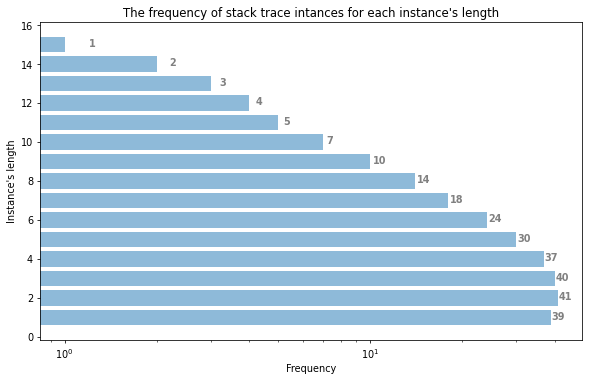

In [99]:
# import matplotlib.pyplot as plt; plt.rcdefaults()
# import numpy as np
# import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize =(10, 6), dpi=70)
ax.barh(list(inst_length), inst_count, align='center', alpha=0.5, log=True)

for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.3,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')

# Add Plot Title
ax.set_title('The frequency of stack trace intances for each instance\'s length',loc ='center')
# ax.set_yticks(y_pos, objects)
ax.set_xlabel('Frequency')
ax.set_ylabel('Instance\'s length')

plt.show()

### Approach (4): CC-Span

In [100]:
def append_to_dicc_new(dicc, vec_id, list_):
    if vec_id not in dicc:
        # key not exist
        dicc[vec_id] = list_
    else:
        # key exist
        for tuple_ in list_:
            for item in dicc[vec_id]:
                if item[0] == tuple_[0]:
                    item[1].append(tuple_[1][0])
                    break
    return dicc

In [101]:
len(_2D_array)

20

In [102]:
# Searching Pattern
low = 1     # <~~~~~~~ define the lower bound threshold
up = len(uniqe_dic)
dicc = {}     

for i_v, vector in enumerate(_2D_array):    
    for index, element in enumerate(vector):
        list_ = []
        for wind_size in range(low, len(vector)+1-index):
            list_.append((wind_size, [(*vector[index:index+wind_size], )]))
        dicc = append_to_dicc_new(dicc, i_v, list_)    

In [103]:
# Counting
def remove_duplication(dup_list):
    final_list = []
    for item in dup_list:
        if item not in final_list:
            final_list.append(item)
        else:
            indx = final_list.index(item)
            counter = final_list[indx][0] + 1
            pair = final_list[indx][1]
            final_list.remove(item)
            final_list.append((counter, pair))
    
    return final_list

In [104]:
dic_count = {}

for vec_i, list_tuples in dicc.items():
#     print(vec_i, list_tuples,"\n")
    for tuples_ in list_tuples:
#         print(tuples_)
        
        if tuples_[0] not in dic_count:
            lst_ = [(1, tuple_) for tuple_ in tuples_[1]] 
            
            if len(lst_) != len(set(lst_)):
                lst_ = remove_duplication(lst_)
            
            dic_count[tuples_[0]] = lst_  
        else:
            #(2, [(1, 3), (1, 4), (3, 4), (4, 5), (5, 1)]
            #break
            for tuple_ in tuples_[1]:
                flag = 0 
                for item in dic_count[tuples_[0]]:
                    if item[1] == tuple_:
                        counter = item[0] + 1
                        dic_count[tuples_[0]].remove(item)
                        dic_count[tuples_[0]].append((counter, item[1]))
                        flag = 1
                        break
                # tuple is new
                if flag == 0:
                    dic_count[tuples_[0]].append((1, tuple_))
#                 else: 
#                     print("Error100")
#     print("salam", dic_count[2], "\n\n" )
#     if vec_i == 1:
#         break

# _2d_array = [[1, 3, 4, 3, 4, 5, 1, 4],
#              [1, 6, 3, 4, 5],
#              [1, 2, 6, 3],
#              [6, 1, 3, 4, 5],
#              [3, 4, 3, 6],
#              [2, 3, 1, 4, 6]]

In [105]:
def is_subsequence(needle: list, haystack: list) -> bool:
    # >>> is_subsequence([2, 3, 4], [1, 2, 3, 4, 5, 6])
    return any(
        haystack[i:i+len(needle)] == needle
        for i in range(len(haystack) - len(needle) + 1)
    )

In [106]:
def CloConSeqGen(dic_count: dict, threshold: int) -> list:
    closed_list = []
    for key, v_list in dic_count.items():
        #print(key, v_list)
        for item_tup in v_list:
            tmp_flag = False
            for key, v_list_search in dic_count.items():
                for item_tup_search in v_list_search:
                    #print("compare with: ", item_tup_search[1])
                    if len(item_tup_search[1]) >= len(item_tup[1]) and is_subsequence(item_tup[1], item_tup_search[1]) and item_tup[1] != item_tup_search[1]:
                        if item_tup[0] == item_tup_search[0]:
                            tmp_flag = True
            if not tmp_flag and item_tup[0] > threshold:

                closed_list.append(item_tup)
    return closed_list

In [107]:
dic_count.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])

In [108]:
def CloConSeqGen_v2(dic_count: dict) -> list:
    closed_list = []
    flag_first_step = True
    for win_size in list(reversed(list(dic_count))):
        # Just add the last or the biggest window_size to the list 
        if flag_first_step:
            flag_first_step = False
            for item in dic_count[win_size]:
                closed_list.append(item)
            continue
        
        # For other window sizes
        for item_tup_new in dic_count[win_size]:
            flag_visit = False
            for item_tup_old in closed_list:
                if item_tup_new[0] == item_tup_old[0] and is_subsequence(item_tup_new[1], item_tup_old[1]):
                    flag_visit = True
                    break
            if not flag_visit:
                closed_list.append(item_tup_new)

    return len(closed_list)

In [109]:
def CloConSeqGen_v3(dic_count: dict, threshold: int) -> list:
    closed_list = []
    removed_closed_list = []
    flag_first_step = True
    for win_size in list(reversed(list(dic_count))):
        # Just add the last or the biggest window_size to the list 
        if flag_first_step:
            for item in dic_count[win_size]:
                if item[0] >= threshold:
                    flag_first_step = False
                    closed_list.append(item)
                else:
                    removed_closed_list.append(item)
            continue
        
        # For other window sizes
        for item_tup_new in dic_count[win_size]:
            flag_visit = False
            for item_tup_old in closed_list:
                if item_tup_new[0] == item_tup_old[0] and is_subsequence(item_tup_new[1], item_tup_old[1]):
                    flag_visit = True
                    break  
            if (not flag_visit) and (item_tup_new[0] >= threshold):
                closed_list.append(item_tup_new)
            else:
                removed_closed_list.append(item_tup_new)

    return closed_list, removed_closed_list

In [110]:
# print(CloConSeqGen_v2(dic_count))
# print(CloConSeqGen_v3(dic_count, 1))
# print(CloConSeqGen_v3(dic_count, 5))

In [111]:
# print(CloConSeqGen_v2(dic_count))
# print(CloConSeqGen_v3(dic_count, threshold=1))
# print(CloConSeqGen_v3(dic_count, threshold=1))
# result, result_remove = CloConSeqGen_v3(dic_count, threshold=2)

### Prepare data for support and pattern length when support is 1

In [112]:
result, result_remove = CloConSeqGen_v3(dic_count, threshold=1)

In [113]:
# Find the low and high boundries of CloConSeqGen_v3 result
for element in result:
    if result.index(element) == 0:
        low = element[0] 
        high = element[0]
        continue
    if low > element[0]:
        low = element[0]
    elif high < element[0]:
        high = element[0]
        
sorted_result = sorted(result, key=lambda tup: tup[0])

sup_x = sorted(set([element[0] for element in result]))
len_sup_y = []

for sup in sup_x:
    len_sup_y.append(len(sorted_result) - [y[0] for y in sorted_result].index(sup))
    
per_len_sup_y = [(x*100)/len_sup_y[0] for x in len_sup_y]

In [114]:
dic_tf_sup = {"x":sup_x, "y":per_len_sup_y}
pickle.dump(dic_tf_sup, open("./Pickle_data/dic_sp_sup.p", "wb"))

In [115]:
win_size_list = []
for element in result:
    win_size_list.append(len(element[1]))
win_size_set = set(win_size_list)
counter=collections.Counter(win_size_list)

counter = dict(sorted(counter.items()))
comulative_y = np.cumsum(list(counter.values()))

per_list_patterns = []
for element in comulative_y:
    per_list_patterns.append((element*100)/comulative_y[-1])

In [116]:
dic_tf_win = {"x":list(counter.keys()), "y":per_list_patterns}
pickle.dump(dic_tf_win, open("./Pickle_data/dic_sp_win.p", "wb"))

### Prepare data for support and pattern length when support is 2

In [117]:
result, result_remove = CloConSeqGen_v3(dic_count, threshold=2)

In [118]:
len(result)

22

In [119]:
def convert_num_string_2d_array(input_list: list, unique_dic: dict) -> list:
    convert_lst = []
    for pattern in input_list:
        string_pattern_lst = []
        for item in pattern:
            string_pattern_lst.append(unique_dic[item])
        convert_lst.append(string_pattern_lst)
    return convert_lst

# convert_num_string_2d_array(_2D_array, uniqe_dic)

In [120]:
def convert_num_string(input_list: list, unique_dic: dict) -> list:
    convert_lst = []
    for pattern in input_list:
        string_pattern_tuple = ()
        for item in pattern[1]:
            string_pattern_tuple = string_pattern_tuple + (unique_dic[item],)
        convert_lst.append((pattern[0], string_pattern_tuple))
    return convert_lst

In [121]:
def order_sublist(lst_big: list, lst_small: list) -> bool:
    return lst_small in [lst_big[i:len(lst_small)+i] for i in range(len(lst_big))]

In [122]:
result_str = convert_num_string(result, uniqe_dic)
assert len(result) == len(result_str), "It should be the same."
pattern_str_w_qid = []

for pattern in result_str:
    for q_id in _Id_array:
        # assert not df_w_sklearn_tags.loc[df_w_sklearn_tags['Id'] == q_id].Bugy_py_files.empty, "It's not possible!"
        exit_flag_q_id = False
        
        for item in df_w_sp_tags['Bugy_py_files'].to_numpy()[df_w_sp_tags['Id'].to_numpy() == q_id].item()[1]:
           
            if order_sublist(item, list(pattern[1])):
                # pattern_str_w_qid.append((pattern[0], pattern[1]))
                
                exist = False
                for ele in pattern_str_w_qid:
                    if ele[1] == pattern[0] and ele[2] == pattern[1]:
                        exist = True
                        ele[0].append(q_id)
                        
                        if len(ele[0]) ==  pattern[0]: exit_flag_q_id = True
                if not exist:
                    pattern_str_w_qid.append((list([q_id]), pattern[0], pattern[1]))
                    if pattern[0] == 1: exit_flag_q_id = True
        
        if exit_flag_q_id: break
            
    # print("\n\n")
pickle.dump(pattern_str_w_qid, open("./Pickle_data/sp_ccspan_2_result_pure.p", "wb"))

In [123]:
result, len(result)

([(2, (8, 9, 10, 11, 12)),
  (2, (14, 15, 6, 16, 7)),
  (2, (4, 5, 6, 16, 7)),
  (2, (1, 4, 5, 6)),
  (3, (26, 6, 16, 7)),
  (3, (8, 9, 10)),
  (2, (1, 2, 1)),
  (3, (4, 5, 6)),
  (9, (6, 16, 7)),
  (2, (6, 7)),
  (4, (26, 6)),
  (10, (6, 16)),
  (2, (18,)),
  (3, (1,)),
  (3, (2,)),
  (2, (23,)),
  (2, (24,)),
  (2, (33,)),
  (3, (15,)),
  (12, (6,)),
  (11, (16,)),
  (11, (7,))],
 22)

In [124]:
result_str, len(result_str)

([(2,
   (('worker', 'main'),
    ('worker', 'process'),
    ('serializers', 'dump_stream'),
    ('regression', '__init__'),
    ('__init__', '_convert_to_vector'))),
  (2,
   (('common', 'call'),
    ('common', 'callJavaFunc'),
    ('java_gateway', '__call__'),
    ('utils', 'deco'),
    ('protocol', 'get_return_value'))),
  (2,
   (('wrapper', '_fit'),
    ('wrapper', '_fit_java'),
    ('java_gateway', '__call__'),
    ('utils', 'deco'),
    ('protocol', 'get_return_value'))),
  (2,
   (('pipeline', 'fit'),
    ('wrapper', '_fit'),
    ('wrapper', '_fit_java'),
    ('java_gateway', '__call__'))),
  (3,
   (('dataframe', 'show'),
    ('java_gateway', '__call__'),
    ('utils', 'deco'),
    ('protocol', 'get_return_value'))),
  (3,
   (('worker', 'main'),
    ('worker', 'process'),
    ('serializers', 'dump_stream'))),
  (2, (('pipeline', 'fit'), ('tuning', '_fit'), ('pipeline', 'fit'))),
  (3,
   (('wrapper', '_fit'),
    ('wrapper', '_fit_java'),
    ('java_gateway', '__call__'))),
 

In [125]:
# win_size_list = []
# for element in result:
#     win_size_list.append(len(element[1]))
# win_size_set = set(win_size_list)
# counter=collections.Counter(win_size_list)

# counter = dict(sorted(counter.items()))
# comulative_y = np.cumsum(list(counter.values()))

# plt.plot(counter.keys(), comulative_y, '--o', color='#4b8262', linewidth=2)

# plt.xlabel('pattern\'s length')
# plt.ylabel('# of patterns')
# plt.title('Spark ML RQ2')
# # plt.text(60, .025, r'$\mu=100,\ \sigma=15$')

# plt.grid(True)
# plt.show()

In [126]:
# win_size_list = []
# for element in result:
#     win_size_list.append(len(element[1]))
# win_size_set = set(win_size_list)
# counter=collections.Counter(win_size_list)

# counter = dict(sorted(counter.items()))
# comulative_y = np.cumsum(list(counter.values()))

# per_list_patterns = []
# for element in comulative_y:
#     per_list_patterns.append((element*100)/comulative_y[-1])
    
# fig = plt.figure(figsize=(6, 4), dpi=100)
# ax1 = fig.add_subplot(111)

# ax1.plot(counter.keys(), per_list_patterns, '--o', color='#4b8262', linewidth=2)
# plt.xlabel('Pattern\'s length')
# plt.ylabel('Cumulative % of stack trace patterns')
# ax1.set_title('RQ2 (Spark ML)')

# plt.vlines(x=5, ymin=60, ymax=95, color='red')

# plt.text(4.5, 45, 'x=5 and y~=80 mean almost 80% of \n patterns have lower than 5 pattern\'s length.', rotation=0)

# ax1.axis(ymin=0, ymax=102)
# ax1.yaxis.set_major_formatter(mtick.PercentFormatter())

# plt.grid(True)
# plt.savefig('length_rq2_ex.pdf')
# plt.show()

In [127]:
def get_top_patterns(patterns_lst: list, top: int) -> list:
    assert top != 0, "The top value is wrong!"
    top_list = []
    support_set = set()
    
    # Find the support list
    for pattern in patterns_lst:
        support_set.add(pattern[0])
        
    top_support_list = sorted(list(support_set))[0:top]
    
    for pattern in patterns_lst:
        if pattern[0] in top_support_list:
            top_list.append(pattern)
            
    return top_list

The below function based on the dic_count dictionary trys to find x top patterns for each window_size

In [128]:
top_pattern_num = get_top_patterns(result, 100)

In [129]:
top_pattern_num

[(2, (8, 9, 10, 11, 12)),
 (2, (14, 15, 6, 16, 7)),
 (2, (4, 5, 6, 16, 7)),
 (2, (1, 4, 5, 6)),
 (3, (26, 6, 16, 7)),
 (3, (8, 9, 10)),
 (2, (1, 2, 1)),
 (3, (4, 5, 6)),
 (9, (6, 16, 7)),
 (2, (6, 7)),
 (4, (26, 6)),
 (10, (6, 16)),
 (2, (18,)),
 (3, (1,)),
 (3, (2,)),
 (2, (23,)),
 (2, (24,)),
 (2, (33,)),
 (3, (15,)),
 (12, (6,)),
 (11, (16,)),
 (11, (7,))]

The below code converts the number pairs to the string pairs

In [130]:
top_pattern_str = convert_num_string(top_pattern_num, uniqe_dic)

In [131]:
len(result), len(top_pattern_num)

(22, 22)

#### Find the Id of a post based on its pattern:

In [132]:
# Before CC-Span dimention
assert len(_2D_array_with_str) == len(_2D_array), "Should be the same." 
len(_2D_array_with_str)

20

In [133]:
# The question IDs that we recorded and used as the input of CC-Span method 
len(_Id_array), _Id_array

(20,
 [32714825,
  51232624,
  49729510,
  37260902,
  63857130,
  58622226,
  33574807,
  40366588,
  40366588,
  54776007,
  53632689,
  60071681,
  46257819,
  54219826,
  53740026,
  48917438,
  33912626,
  73431344,
  73264786,
  69792429])

In [134]:
def order_sublist(lst_big: list, lst_small: list) -> bool:
    return lst_small in [lst_big[i:len(lst_small)+i] for i in range(len(lst_big))]

In [135]:
result, result_remove = CloConSeqGen_v3(dic_count, threshold=2)

In [136]:
len(result)

22

In [137]:
def find_q_id_based_on_str_pattern(total_IDs: list, pattern_str_lst: list) -> dict:
    dict_pattern_and_qid = {}
    
    for pattern in pattern_str_lst:
        for q_id in total_IDs:
            assert not df_w_sp_tags.loc[df_w_sp_tags['Id'] == q_id].Bugy_py_files.empty, "It's not possible!"

            for item in df_w_sp_tags.loc[df_w_sp_tags['Id'] == q_id].Bugy_py_files.values[0][1]:
                if order_sublist(item, list(pattern[1])):
                    pattern_tpl = (*pattern[1], )
                    if pattern_tpl not in dict_pattern_and_qid.keys():
                        dict_pattern_and_qid[pattern_tpl] = set({q_id})
                    else:
                        dict_pattern_and_qid[pattern_tpl].add(q_id)
    return dict_pattern_and_qid

In [138]:
def get_q_number(dict_pattern_and_qid: dict) -> int:
    q_total_set = set({})
    
    for key, value in dict_pattern_and_qid.items():
        # print(value)
        q_total_set.update(value)

    return len(q_total_set), q_total_set

In [139]:
dict_pattern_and_qid = find_q_id_based_on_str_pattern(_Id_array, convert_num_string(result, uniqe_dic))
get_q_number(dict_pattern_and_qid)

(16,
 {32714825,
  33574807,
  33912626,
  37260902,
  40366588,
  46257819,
  48917438,
  49729510,
  51232624,
  53632689,
  54219826,
  54776007,
  58622226,
  60071681,
  63857130,
  69792429})

In [140]:
# result_str

In [141]:
# dict_pattern_and_qid

### Create covered question plot

Create the x-axist: sorted based on the support

In [142]:
result_str_rev_sorted = sorted(result_str, key=lambda tup: tup[0], reverse=True)
x_number_of_patterns = list(range(1, len(result_str_rev_sorted)+1))

Create the y-axist: % of coverd questions

In [143]:
number_of_unique_questions, set_of_unique_questions = get_q_number(dict_pattern_and_qid)

In [144]:
visited_questions = set()
y_axis_peresentage_of_coverage = []
for support, pattern in result_str_rev_sorted:    
    visited_questions.update(dict_pattern_and_qid[pattern])
    if len(visited_questions) < len(set_of_unique_questions):
        y_axis_peresentage_of_coverage.append(len(visited_questions)*100/len(set_of_unique_questions))
    elif len(visited_questions) > len(set_of_unique_questions):
        print("Error(100)!")
    elif len(visited_questions) == len(set_of_unique_questions):
        y_axis_peresentage_of_coverage.append(100)

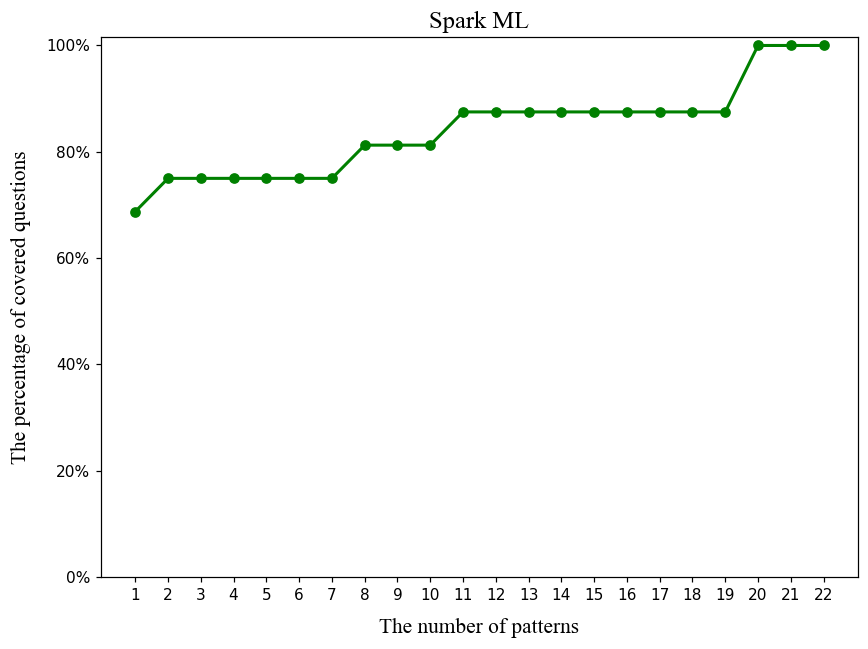

In [145]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=110)

ax.plot(x_number_of_patterns, y_axis_peresentage_of_coverage, '-o', color='green', linewidth=2)

ax.set_title('Spark ML', fontname="Times New Roman", fontsize=16)

ax.set_xlabel('The number of patterns', labelpad=10, fontname="Times New Roman", fontsize=14)
ax.set_xticks(range(1, max(x_number_of_patterns)+1, 1))

ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('The percentage of covered questions', labelpad=10, fontname="Times New Roman", fontsize=14)
ax.set_yticks(range(0, 101, 20))


fig.tight_layout()
# plt.savefig('sp_le_rq1.pdf')
plt.show()

In [146]:
plt_dic_sp_covered_ques = {"x":x_number_of_patterns, "y":y_axis_peresentage_of_coverage}
pickle.dump(plt_dic_sp_covered_ques, open("./Pickle_data/plt_dic_sp_covered_ques.p", "wb"))

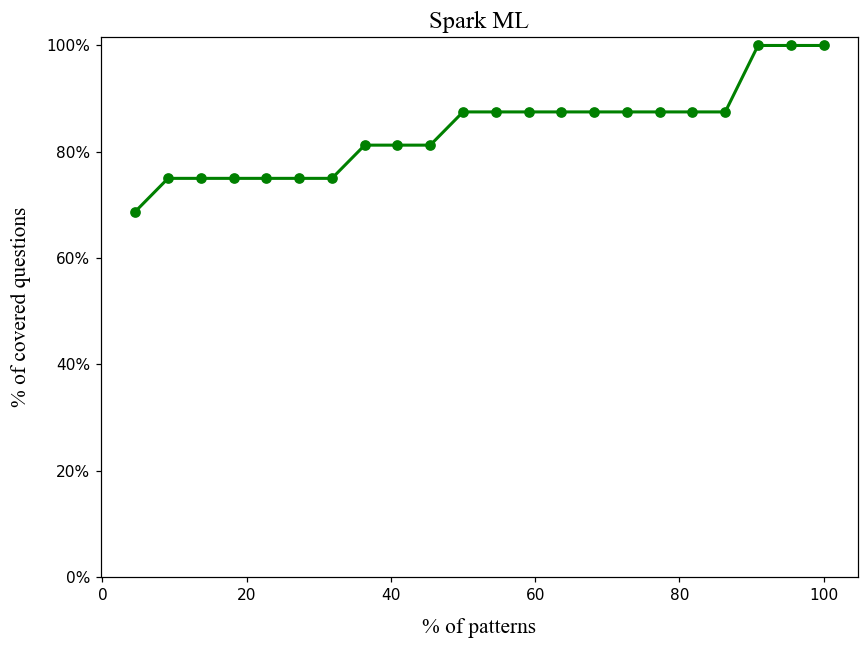

In [147]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=110)

x_number_of_patterns_n = [ x*100/len(x_number_of_patterns) for x in x_number_of_patterns]

ax.plot(x_number_of_patterns_n, y_axis_peresentage_of_coverage, '-o', color='green', linewidth=2)

ax.set_title('Spark ML', fontname="Times New Roman", fontsize=16)

ax.set_xlabel('% of patterns', labelpad=10, fontname="Times New Roman", fontsize=14)
ax.set_yticks(range(0, 101, 20))

ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('% of covered questions', labelpad=10, fontname="Times New Roman", fontsize=14)
ax.set_yticks(range(0, 101, 20))

fig.tight_layout()
# plt.savefig('sp_le_rq1.pdf')
plt.show()

In [148]:
lst_q_id_has_pattern = []
for top_pattern in top_pattern_str:
    # print("Pattern(small set): \t", top_pattern[1])
    for q_id in _Id_array:
        # print(q_id)
        assert not df_w_sp_tags.loc[df_w_sp_tags['Id'] == q_id].Bugy_py_files.empty, "It's not possible!"
        
        for item in df_w_sp_tags.loc[df_w_sp_tags['Id'] == q_id].Bugy_py_files.values[0][1]:
            # print("Big set: \t", item)
            if order_sublist(item, list(top_pattern[1])):
                # print("Big Set: \t", item)
                # print("Small Set: \t", list(top_pattern[1]))
                # print("\n\n")
                lst_q_id_has_pattern.append(q_id)
    # print("\n\n")

In [149]:
assert lst_q_id_has_pattern, "It not should be empty."

In [150]:
df_pattern = df_w_sp_tags.loc[df_w_sp_tags['Id'].isin(lst_q_id_has_pattern)].reset_index(drop=True)

In [151]:
df_pattern.rename(columns = {'Id':'Q_id', 'CreationDate':'Q_create_time'}, inplace = True)

In [152]:
pure_data = working_directory_path + "db_results/" + "spark_ans_all.csv"
path = Path(pure_data)

if path.suffix == ".csv":
    df_night = pd.read_csv(path, encoding=encoding)
else:
    raise ValueError("{data_file_path.suffix} extensions are not supported")

In [153]:
pd_tmp_w = pd.merge(df_pattern, df_night, how='outer',left_on=['Q_id'], right_on=['ParentId']).reset_index(drop=True)

pd_tmp_w["Answer_tup"] = pd_tmp_w.apply(lambda x: (x.Id, x.CreationDate), axis=1)

pd_tmp_new_w = pd_tmp_w.groupby(["Q_id_x", "Q_create_time", "ViewCount", "CommentCount", "Score", "AnswerCount", "AcceptedAnswerId"], dropna=False)["Answer_tup"].agg(list).reset_index()
df_pattern_ans = pd_tmp_new_w[pd_tmp_new_w.AnswerCount != 0].reset_index(drop=True)

In [154]:
df_pattern_ans = df_pattern_ans[df_pattern_ans.AcceptedAnswerId > 0]

In [155]:
def check_patt_ans(lst_ans_id_1, lst_ans_id_2):
    assert set(lst_ans_id_1) == set(lst_ans_id_2), "We couldn't find all answers."
    assert len(lst_ans_id_1) == len(lst_ans_id_2), "The length of answer lists are not the same."

In [156]:
check_patt_ans(df_pattern_ans.AcceptedAnswerId, df_pattern[df_pattern.AcceptedAnswerId > 0].AcceptedAnswerId)

In [157]:
df_pattern_ans.insert(len(df_pattern_ans.columns), 'First_ans_time', np.nan)
df_pattern_ans.insert(len(df_pattern_ans.columns), 'First_acc_ans_time', np.nan)

In [158]:
def assign_the_answers(df: pd.DataFrame) -> pd.DataFrame:
    for index1, row_status in df.iterrows():   
        flag = 0
        fr_time = pd.to_datetime(datetime.datetime.now())
        acc_time = pd.to_datetime(datetime.datetime.now())

        if not row_status["Answer_tup"]:
            pd_tmp_new3_w.at[index1,'First_ans_time'] = np.nan
            pd_tmp_new3_w.at[index1,'First_acc_ans_time'] = np.nan
            continue

        for answer in row_status["Answer_tup"]:

            anwer_time = pd.to_datetime(answer[1])

            if flag == 0:
                fr_time = anwer_time
                flag = 1

            if fr_time > anwer_time:
                fr_time = anwer_time

            if row_status["AcceptedAnswerId"] == answer[0]:
                acc_time = anwer_time

        df.at[index1,'First_ans_time'] = fr_time

        if pd.isna(row_status["AcceptedAnswerId"]):
            acc_time = np.nan

        df.at[index1,'First_acc_ans_time'] = acc_time
    return df

In [159]:
df_pattern_ans = assign_the_answers(df_pattern_ans)

In [160]:
df_pattern_ans["Q_create_time"]      = pd.to_datetime(df_pattern_ans["Q_create_time"])
df_pattern_ans["First_acc_ans_time"] = pd.to_datetime(df_pattern_ans["First_acc_ans_time"])
df_pattern_ans["First_ans_time"]     = pd.to_datetime(df_pattern_ans["First_ans_time"])

In [161]:
df_pattern_ans["Duration_ans"] = df_pattern_ans.apply(lambda row: (row.First_ans_time-row.Q_create_time).total_seconds()/3600 if not pd.isna(row.First_ans_time) else np.nan, axis=1)
df_pattern_ans["Duration_acc_ans"] = df_pattern_ans.apply(lambda row: (row.First_acc_ans_time-row.Q_create_time).total_seconds()/3600 if not pd.isna(row.First_acc_ans_time) else np.nan, axis=1)

In [162]:
df_pattern_ans

,Q_id_x,Q_create_time,ViewCount,CommentCount,Score,AnswerCount,AcceptedAnswerId,Answer_tup,First_ans_time,First_acc_ans_time,Duration_ans,Duration_acc_ans
0,33574807.0,2015-11-06 20:02:43,13254.0,0.0,17.0,2.0,33579202.0,"[(33579202.0, 2015-11-07 04:41:48), (33583048....",2015-11-07 04:41:48,2015-11-07 04:41:48,8.651389,8.651389
1,33912626.0,2015-11-25 09:20:33,920.0,2.0,4.0,1.0,34642875.0,"[(34642875.0, 2016-01-06 21:14:12)]",2016-01-06 21:14:12,2016-01-06 21:14:12,1019.894167,1019.894167
4,46257819.0,2017-09-16 19:42:56,1592.0,0.0,2.0,1.0,46257990.0,"[(46257990.0, 2017-09-16 20:03:55)]",2017-09-16 20:03:55,2017-09-16 20:03:55,0.349722,0.349722
5,48917438.0,2018-02-21 23:50:51,827.0,0.0,2.0,1.0,48936379.0,"[(48936379.0, 2018-02-22 20:12:36)]",2018-02-22 20:12:36,2018-02-22 20:12:36,20.362500,20.362500
6,49729510.0,2018-04-09 09:19:08,492.0,0.0,2.0,1.0,49729605.0,"[(49729605.0, 2018-04-09 09:24:30)]",2018-04-09 09:24:30,2018-04-09 09:24:30,0.089444,0.089444
7,51232624.0,2018-07-08 13:47:43,652.0,0.0,0.0,1.0,51232979.0,"[(51232979.0, 2018-07-08 14:31:34), (66632051....",2018-07-08 14:31:34,2018-07-08 14:31:34,0.730833,0.730833
8,53632689.0,2018-12-05 12:46:41,461.0,0.0,0.0,1.0,53636176.0,"[(53636176.0, 2018-12-05 15:59:24)]",2018-12-05 15:59:24,2018-12-05 15:59:24,3.211944,3.211944
9,54776007.0,2019-02-19 22:36:58,384.0,2.0,1.0,1.0,54776264.0,"[(54776264.0, 2019-02-19 23:05:12)]",2019-02-19 23:05:12,2019-02-19 23:05:12,0.470556,0.470556
11,69792429.0,2021-11-01 03:45:48,2096.0,1.0,1.0,1.0,69849566.0,"[(69849566.0, 2021-11-05 06:57:14)]",2021-11-05 06:57:14,2021-11-05 06:57:14,99.190556,99.190556


In [163]:
df_result = pd.DataFrame(columns=['Index', 'Q_id', 'Title', 'OS', '# ST-Post', '# ST', 'Link'])

for _indx, row in df_pattern.iterrows():
    _c = 0
    for item in row.Bugy_py_files[1]:
        _c += len(item)
    _link = "https://stackoverflow.com/questions/" + str(row.Q_id)
    tmp_dic = {'Index': _indx+1, 'Q_id': row.Q_id, 'Title': row.Title, 'OS': row.Bugy_py_files[0], '# ST-Post': len(row.Bugy_py_files[1]), '# ST': _c, 'Link': _link}
    df2 = pd.DataFrame(tmp_dic, index={len(tmp_dic)+1})
    df_result = pd.concat([df_result, df2], ignore_index=True)

In [164]:
regex_unix    = r"[^\n\&\:\|\>\<\/\ \"\;\&]*(\/[^\n\&\:\|\>\<\/]+)+\/([^\n\&\:\|\>\<\/\\]+)(\.pyc|\.py)[^\d\n]+(\d*)\W*in\s\W*\d*([a-zA-Z_$][a-zA-Z_$0-9]*)"
regex_windows = r"(([a-zA-Z]:)|\~)\\?\/?([^\<\>\:\"\\\|\?\*\n]+\\)+([^\<\>\:\"\\\/\/\|\?\*\n]+)(\.pyc|\.py)[^\d\n]+(\d*)\W*in\W+([a-zA-Z_$][a-zA-Z_$0-9]*)"
# https://regex101.com/r/5yCAdA/1   Unix
# https://regex101.com/r/50Vcmo/1 Windows

In [165]:
pd.options.display.max_colwidth = 500
df_pattern.loc[df_pattern.Q_id == 54219826].Bugy_py_files

12    (unix, [[('base', 'fit'), ('wrapper', '_fit'), ('wrapper', '_fit_java'), ('java_gateway', '__call__'), ('utils', 'deco'), ('protocol', 'get_return_value')]])
Name: Bugy_py_files, dtype: object

In [166]:
df_pattern.loc[df_pattern.Q_id == 54219826]

,Q_id,PostTypeId,AcceptedAnswerId,Q_create_time,ViewCount,AnswerCount,CommentCount,Score,Title,Body,Tags,Source,source,Code,Has_code,Text,Q_text_words_num,Bugy_py_files,Has_trace,Line_code_u_w_s,Line_code_uix,Line_code_win,Line_code_simple_code
12,54219826,1,NaN,2019-01-16 15:00:02,30,0,4,0,java exception trying to use StringIndexer,"<p>I am trying to use StringIndexer in a dataframe but i am having trouble with pyspark and can't recognize what is wrong.</p>\n\n<p>The PySpark docummentation tells:\n""Additionally, there are two strategies regarding how StringIndexer will handle unseen labels when you have fit a StringIndexer on one dataset and then use it to transform another:</p>\n\n<p>throw an exception (which is the default)\nskip the row containing the unseen label entirely""</p>\n\n<p>I tried to use 'setHandleValid' b...",<python><apache-spark><pyspark><apache-spark-sql><apache-spark-ml>,old,NaN,"[from pyspark.ml.feature import StringIndexer\n\nindexer = StringIndexer(inputCol=""tipo_guia"", outputCol=""cidIndex"")\nindexed = indexer.fit(df).setHandleInvalid(""keep"").transform(df)\n\nindexed.show()\n, Py4JJavaErrorTraceback (most recent call last)\n&lt;ipython-input-20-96812db7253c&gt; in &lt;module&gt;()\n 2 \n 3 indexer = StringIndexer(inputCol=""tipo_guia"", outputCol=""cidIndex"")\n----&gt; 4 indexed = indexer.fit(df).setHandleInvalid(""keep"").transform(df)\n 5 \n 6 ind...",True,"[I am trying to use StringIndexer in a dataframe but i am having trouble with pyspark and can't recognize what is wrong., The PySpark docummentation tells:\n""Additionally, there are two strategies regarding how StringIndexer will handle unseen labels when you have fit a StringIndexer on one dataset and then use it to transform another:, throw an exception (which is the default)\nskip the row containing the unseen label entirely"", I tried to use 'setHandleValid' but didn't work., i am receivi...",82,"(unix, [[('base', 'fit'), ('wrapper', '_fit'), ('wrapper', '_fit_java'), ('java_gateway', '__call__'), ('utils', 'deco'), ('protocol', 'get_return_value')]])",True,"(96, 0, 4)",96,0,4


In [167]:
lst_id_has_trace_wo_err_mess = []
c_has_trace   = 0
c_has_err_mes = 0

def extract_error_messages(id: int, Has_code: bool, Has_trace: bool, code_sec: List) -> Optional[List]:
    try:
        global lst_id_has_trace_wo_err_mess, c_has_trace, c_has_err_mes
        
        if Has_trace: c_has_trace += 1
        # if not (Has_trace and Has_code): print(f"Error (2): It's not possiable. Has_code: {Has_code}, Has_trace: {Has_trace}")
            
        result_total = []
        
        for code in code_sec:
            # regex = r"([A-Z]\w+(Error|Warning|Exception))([^:]*):\s(.*)$"
            # V3
            regex = r"^([A-Z]\w+Error)(\w|\s|\(|\)|\d)*:\s(.*)$"
            # regex = r"([A-Z]\w+Error):\s(.*)$"
            code = code.replace("\\n", "\n")
            code = code.replace('&lt;', '<')
            code = code.replace('&gt;', '>')
            code = code.replace('&quot;', '"')
            matches = re.finditer(regex, code, re.MULTILINE)
            result_each_code_part = []

            for matchNum, match in enumerate(matches, start=1):
                result_each_code_part.append((match.groups()[0].strip(), match.groups()[2].strip()))
            
            if result_each_code_part:   # Ignore the empty list
                result_total.append(result_each_code_part)

        if (not result_total) and Has_trace: 
            # print("Warning!: We have to check this is ID: ", id)
            lst_id_has_trace_wo_err_mess.append(id)
        
        if result_total:
            c_has_err_mes += len(result_total)
            
        return result_total
    
    except:
        print("Error(1): ", id)
        print(code_sec)
        return None

In [168]:
df_pattern["Err_msg"] = df_pattern.apply(lambda row: extract_error_messages(row.Q_id, row.Has_code, row.Has_trace, row.Code), axis=1)

In [169]:
print(f"We captured {c_has_trace} stack traces, however {c_has_trace-len(lst_id_has_trace_wo_err_mess)} stacktraces have a one type of error messages. I mean, {len(lst_id_has_trace_wo_err_mess)} stack traces didn't have any error message.")

We captured 16 stack traces, however 10 stacktraces have a one type of error messages. I mean, 6 stack traces didn't have any error message.


In [170]:
df_tmp = df_pattern[df_pattern['Err_msg'].map(lambda err_msg_list: len(err_msg_list)) > 0]
df_tmp.reset_index(drop=True, inplace=True)

In [171]:
df_pattern_err_msg = pd.DataFrame(columns=['Q_id', 'ErrorType', 'ErrorMessage'])

In [172]:
def message_extractor(msg_q_id: str, msg_list: list) -> None:
    global df_pattern_err_msg
    for msg_t in msg_list:
        for message in msg_t:
            df_pattern_err_msg = pd.concat([df_pattern_err_msg, pd.DataFrame.from_records([{'Q_id': msg_q_id, 'ErrorType': message[0], 'ErrorMessage': message[1]}])], ignore_index=True)

In [173]:
_ = df_tmp.apply(lambda row: message_extractor(row.Q_id, row.Err_msg), axis=1)

In [174]:
df_pattern_err_msg.shape

(14, 3)

In [175]:
df_pattern_err_msg

,Q_id,ErrorType,ErrorMessage
0,32714825,Py4JJavaError,An error occurred while calling o59.fit.
1,51232624,Py4JJavaError,An error occurred while calling o6652.meanSquaredError.
2,51232624,TypeError,Cannot convert type <type 'float'> into Vector
3,51232624,TypeError,Cannot convert type <type 'float'> into Vector
4,49729510,Py4JJavaError,An error occurred while calling o371.precision.
5,49729510,TypeError,field prediction: DoubleType can not accept object 0 in type <type 'int'>
6,63857130,IndexError,pop from an empty deque
7,63857130,ConnectionRefusedError,[Errno 111] Connection refused
8,58622226,AttributeError,'GBTClassificationModel' object has no attribute 'fitMultiple'
9,40366588,Py4JJavaError,An error occurred while calling o562.areaUnderROC.


In [176]:
# Make sure all the elements are string
df_pattern_err_msg = df_pattern_err_msg.applymap(str)

# Notice: strip() function will remove leading and trailing whitespaces.
df_pattern_err_msg['ErrorType'] = df_pattern_err_msg['ErrorType'].apply(lambda x: x.strip())

/tmp/ipykernel_3092/105255407.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'ErrorType': 'Other', 'count': df_tmp['count'].iloc[TOP:].sum()}, ignore_index=True)


(-1.10000000035053,
 1.1000000073611296,
 -1.1087738281201618,
 1.1004178013390553)

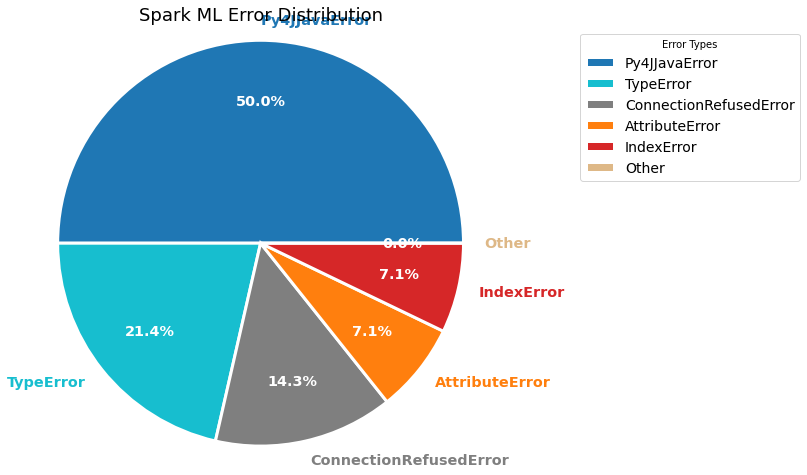

In [177]:
TOP = 6
df_tmp = df_pattern_err_msg.groupby(['ErrorType'])['ErrorType'].count().reset_index(name='count').sort_values(['count'], ascending=False)
df2 = df_tmp.iloc[:TOP]
df2 = df2.append({'ErrorType': 'Other', 'count': df_tmp['count'].iloc[TOP:].sum()}, ignore_index=True)
colors = ['tab:blue', 'tab:cyan', 'tab:gray', 'tab:orange', 'tab:red', 'burlywood', 'y']

fig, ax = plt.subplots(figsize=(8, 8))

patches, texts, pcts =  ax.pie(df2.set_index('ErrorType')['count'],
                               labels=df2['ErrorType'],
                                autopct='%1.1f%%', 
                                pctdistance=0.7, 
                                labeldistance=1.1, 
                                # textprops={'fontsize': 12},
                                textprops={'size': 'x-large'},
                                colors=colors,
                                wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},)

s = df2.groupby('ErrorType')['count'].sum().map(lambda x : x).sort_values(ascending = False)
labels = [f'{name}, {percentage*100:0.1f}%' for name, percentage in zip(s.index, s / s.sum())]
ax.legend(bbox_to_anchor=(1.2, 1), 
           loc='upper left', 
           # labels=labels,
           title="Error Types",
           # labelcolor=colors,
           fontsize=14)


plt.setp(pcts, color='white', fontweight='bold')
ax.set_title("Spark ML Error Distribution", fontsize=18)
for i, patch in enumerate(patches):
    texts[i].set_color(patch.get_facecolor())
    
plt.setp(texts, fontweight=600)

ax.axis('equal')  
# plt.tight_layout()
# ax.figure.savefig('piechart.png', bbox_inches='tight')

In [178]:
# Get the frequency of each message type
print(df_pattern_err_msg.groupby(['ErrorType'])['ErrorType'].count().reset_index(name='count').sort_values(['count'], ascending=False).nlargest(10, 'count'))
df_pattern_err_msg.shape

                ErrorType  count
3           Py4JJavaError      7
4               TypeError      3
1  ConnectionRefusedError      2
0          AttributeError      1
2              IndexError      1


(14, 3)

In [179]:
print("Score median: ", df_pattern.Score.median())
print("View median: ", df_pattern.ViewCount.median())
print("Answer_count median: ", df_pattern.AnswerCount.median())
print("Comment median: ", df_pattern.CommentCount.median())
print("# Accepted answer:", df_pattern.AcceptedAnswerId.count(), "  Total Accepted answer:", df_pattern.AcceptedAnswerId.shape[0], "  Percentage of Accepted answer:", "{:.2f}".format(df_pattern.AcceptedAnswerId.count() *100 / df_pattern.AcceptedAnswerId.shape[0]))
print("LOC median: ", (df_pattern[df_pattern.Has_trace == True].Line_code_win + df_pattern[df_pattern.Has_trace == True].Line_code_uix).median())
print("LOP median: ", df_pattern.Q_text_words_num.median())
print("Answer duration median: ", "{:.2f}".format(df_pattern_ans.Duration_ans.median()))
print("Accepted Answer duration median: ", "{:.2f}".format(df_pattern_ans.Duration_acc_ans.median()))

Score median:  1.5
View median:  739.5
Answer_count median:  1.0
Comment median:  0.5
# Accepted answer: 9   Total Accepted answer: 16   Percentage of Accepted answer: 56.25
LOC median:  55.0
LOP median:  83.5
Answer duration median:  3.21
Accepted Answer duration median:  3.21


In [180]:
df_pattern_err_msg.Q_id = df_pattern_err_msg.Q_id.astype(int)
df_result.Q_id = df_result.Q_id.astype(int)
df_result_mrg = pd.merge(df_pattern_err_msg, df_result, on=["Q_id"], how='right')

In [181]:
from tabulate import tabulate
print(tabulate(df_pattern_err_msg, headers='keys', tablefmt='psql', showindex=False))
print(tabulate(df_result, headers='keys', tablefmt='psql', showindex=False))

+----------+------------------------+---------------------------------------------------------------------------+
|     Q_id | ErrorType              | ErrorMessage                                                              |
|----------+------------------------+---------------------------------------------------------------------------|
| 32714825 | Py4JJavaError          | An error occurred while calling o59.fit.                                  |
| 51232624 | Py4JJavaError          | An error occurred while calling o6652.meanSquaredError.                   |
| 51232624 | TypeError              | Cannot convert type <type 'float'> into Vector                            |
| 51232624 | TypeError              | Cannot convert type <type 'float'> into Vector                            |
| 49729510 | Py4JJavaError          | An error occurred while calling o371.precision.                           |
| 49729510 | TypeError              | field prediction: DoubleType can not accept object

In [182]:
import os
from openpyxl import load_workbook


def append_df_to_excel(filename, df, sheet_name='Sheet1', startrow=None,
                       truncate_sheet=False, 
                       **to_excel_kwargs):
    """
    Append a DataFrame [df] to existing Excel file [filename]
    into [sheet_name] Sheet.
    If [filename] doesn't exist, then this function will create it.

    @param filename: File path or existing ExcelWriter
                     (Example: '/path/to/file.xlsx')
    @param df: DataFrame to save to workbook
    @param sheet_name: Name of sheet which will contain DataFrame.
                       (default: 'Sheet1')
    @param startrow: upper left cell row to dump data frame.
                     Per default (startrow=None) calculate the last row
                     in the existing DF and write to the next row...
    @param truncate_sheet: truncate (remove and recreate) [sheet_name]
                           before writing DataFrame to Excel file
    @param to_excel_kwargs: arguments which will be passed to `DataFrame.to_excel()`
                            [can be a dictionary]
    @return: None

    Usage examples:

    >>> append_df_to_excel('d:/temp/test.xlsx', df)

    >>> append_df_to_excel('d:/temp/test.xlsx', df, header=None, index=False)

    >>> append_df_to_excel('d:/temp/test.xlsx', df, sheet_name='Sheet2',
                           index=False)

    >>> append_df_to_excel('d:/temp/test.xlsx', df, sheet_name='Sheet2', 
                           index=False, startrow=25)

    (c) [MaxU](https://stackoverflow.com/users/5741205/maxu?tab=profile)
    """
    # Excel file doesn't exist - saving and exiting
    if not os.path.isfile(filename):
        df.to_excel(
            filename,
            sheet_name=sheet_name, 
            startrow=startrow if startrow is not None else 0, 
            **to_excel_kwargs)
        return
    
    # ignore [engine] parameter if it was passed
    if 'engine' in to_excel_kwargs:
        to_excel_kwargs.pop('engine')

    writer = pd.ExcelWriter(filename, engine='openpyxl', mode='a', if_sheet_exists='replace')

    # try to open an existing workbook
    writer.book = load_workbook(filename)
    
    # get the last row in the existing Excel sheet
    # if it was not specified explicitly
    if startrow is None and sheet_name in writer.book.sheetnames:
        startrow = writer.book[sheet_name].max_row

    # truncate sheet
    if truncate_sheet and sheet_name in writer.book.sheetnames:
        # index of [sheet_name] sheet
        idx = writer.book.sheetnames.index(sheet_name)
        # remove [sheet_name]
        writer.book.remove(writer.book.worksheets[idx])
        # create an empty sheet [sheet_name] using old index
        writer.book.create_sheet(sheet_name, idx)
    
    # copy existing sheets
    writer.sheets = {ws.title:ws for ws in writer.book.worksheets}

    if startrow is None:
        startrow = 0

    # write out the new sheet
    df.to_excel(writer, sheet_name, startrow=startrow, **to_excel_kwargs)

    # save the workbook
    writer.save()

In [183]:
# df_result_mrg.drop("Index", axis=1, inplace=True)
# df_result_mrg.to_excel("../Emp_st_p_1.xlsx", sheet_name='Spark_ML') 
df_result_mrg.drop("Index", axis=1, inplace=True)
append_df_to_excel("../Emp_st_p_1.xlsx", df_result_mrg, sheet_name='Spark_ML')

## Answer time

### Loading Answer Dataset

In [184]:
# pure_ans_data = working_directory_path + "ansSample.csv"
# path_ans = Path(pure_ans_data)

# if path_ans.suffix == ".csv":
#     df_ans = pd.read_csv(path_ans, encoding=encoding)
# else:
#     raise ValueError("{data_file_path.suffix} extensions are not supported")

## Create DF based on the questions contain stack traces

In [185]:
df_status_w_stack = pd.DataFrame(columns=['First_ans_time', 'First_acc_ans_time', 'Answers'])

In [186]:
df_status_w_stack["Q_info"] = Question_with_trace_info

In [187]:
Question_with_trace_info[0]

(32714825, '2015-09-22 10:44:13', 2079, 0, 12, 6, nan)

In [188]:
df_status_w_stack["Q_id"]          = df_status_w_stack['Q_info'].apply(lambda q_info: q_info[0])
df_status_w_stack["Q_create_time"] = df_status_w_stack['Q_info'].apply(lambda q_info: q_info[1])
df_status_w_stack["View_count"]    = df_status_w_stack['Q_info'].apply(lambda q_info: q_info[2])
df_status_w_stack["Answer_count"]  = df_status_w_stack['Q_info'].apply(lambda q_info: q_info[3])
df_status_w_stack["Comment_count"] = df_status_w_stack['Q_info'].apply(lambda q_info: q_info[4])
df_status_w_stack["Score"]         = df_status_w_stack['Q_info'].apply(lambda q_info: q_info[5])
df_status_w_stack["Accepted_Answer_id"] = df_status_w_stack['Q_info'].apply(lambda q_info: q_info[6])

In [189]:
df_status_w_stack = df_status_w_stack.drop(['Q_info'], axis='columns')

In [190]:
df_status_w_stack["Q_create_time"]      = pd.to_datetime(df_status_w_stack["Q_create_time"])
df_status_w_stack["First_acc_ans_time"] = pd.to_datetime(df_status_w_stack["First_acc_ans_time"])
df_status_w_stack["First_ans_time"]     = pd.to_datetime(df_status_w_stack["First_ans_time"])

#### Filling the Answers column: A list contains the id and time of answers

We have to prepare and find answers that has sp parrentID, so first we catch the questions and store as table in DB. Before this job we have to create a table with all answrs and apply inner join to those tables:

In [191]:
df_status_w_stack["Q_id"].to_csv('../code_output_csv/df_sp_w_stack.csv', encoding='utf-8')

In [192]:
pure_data = working_directory_path + "db_results/" + "spark_ans_all.csv"
path = Path(pure_data)

if path.suffix == ".csv":
    df_night = pd.read_csv(path, encoding=encoding)
else:
    raise ValueError("{data_file_path.suffix} extensions are not supported")

In [193]:
# df_status_w_stack['Answers'] = df_status_w_stack.apply(lambda x: [], axis=1)

In [194]:
# for index1, row_status in df_status_w_stack.iterrows():
#     for index2, row_night in df_night.iterrows():
#             if row_night["ParentId"] == row_status["Q_id"]:
#                     row_status['Answers'].append((row_night["Id"], row_night["CreationDate"]))

In [195]:
df_status_w_stack.head()

,First_ans_time,First_acc_ans_time,Answers,Q_id,Q_create_time,View_count,Answer_count,Comment_count,Score,Accepted_Answer_id
0,NaT,NaT,NaN,32714825,2015-09-22 10:44:13,2079,0,12,6,NaN
1,NaT,NaT,NaN,51232624,2018-07-08 13:47:43,652,1,0,0,51232979.0
2,NaT,NaT,NaN,49729510,2018-04-09 09:19:08,492,1,0,2,49729605.0
3,NaT,NaT,NaN,37260902,2016-05-16 18:36:08,7846,3,2,14,NaN
4,NaT,NaT,NaN,63857130,2020-09-12 05:26:56,60,0,0,0,NaN


In [196]:
pd_tmp_w = pd.merge(df_status_w_stack, df_night, how='outer',left_on=['Q_id'], right_on=['ParentId']).reset_index(drop=True)

pd_tmp_w["Answer_tup"] = pd_tmp_w.apply(lambda x: (x.Id, x.CreationDate), axis=1)

pd_tmp_new_w = pd_tmp_w.groupby(["Q_id_x", "Q_create_time", "View_count", "Comment_count", "Score", "Answer_count", "Accepted_Answer_id"], dropna=False)["Answer_tup"].agg(list).reset_index()
pd_tmp_new2_w = pd_tmp_new_w[pd_tmp_new_w.Answer_count != 0].reset_index(drop=True)

In [197]:
# df_status_w_stack["Answers"] = df_status_w_stack["Answers"].apply(lambda answers_list: list(set(answers_list)))

In [198]:
def checker_1(i, answers_list, answers_count):
    global counter
    if len(answers_list) != answers_count:
        print("Error ", i, len(answers_list), answers_count)

def checker_ans_and_ans_tup(row_indx: int, ans_count: int, ans_list: list) -> None:
    if len(ans_list) < ans_count:
        print("Error!: ", row_indx, ans_count, ans_list)

In [199]:
# df_status_w_stack.apply(lambda row: checker_1(row.name, row.Answers, row.Answer_count), axis=1)
_ = pd_tmp_new2_w.apply(lambda row: checker_ans_and_ans_tup(row.name, row.Answer_count, row.Answer_tup), axis=1)

In [200]:
pd_tmp_new2_w.insert(len(pd_tmp_new2_w.columns), 'First_ans_time', np.nan)
pd_tmp_new2_w.insert(len(pd_tmp_new2_w.columns), 'First_acc_ans_time', np.nan)

In [201]:
pd_tmp_new3_w = pd_tmp_new2_w.copy()

In [202]:
for index1, row_status in pd_tmp_new3_w.iterrows():   
    flag = 0
    fr_time = pd.to_datetime(datetime.datetime.now())
    acc_time = pd.to_datetime(datetime.datetime.now())
        
    if not row_status["Answer_tup"]:
        pd_tmp_new3_w.at[index1,'First_ans_time'] = np.nan
        pd_tmp_new3_w.at[index1,'First_acc_ans_time'] = np.nan
        continue

    for answer in row_status["Answer_tup"]:
        
        anwer_time = pd.to_datetime(answer[1])
        
        if flag == 0:
            fr_time = anwer_time
            flag = 1
        
        if fr_time > anwer_time:
            fr_time = anwer_time
        
        if row_status["Accepted_Answer_id"] == answer[0]:
            acc_time = anwer_time

    pd_tmp_new3_w.at[index1,'First_ans_time'] = fr_time
        
    if pd.isna(row_status["Accepted_Answer_id"]):
        acc_time = np.nan
    
    pd_tmp_new3_w.at[index1,'First_acc_ans_time'] = acc_time

In [203]:
# df_status_w_stack.info()

Write df_status_w_stack to the CSV file:

In [204]:
# df_status_w_stack.to_csv('./status_PT_df_w_stack_with_list_of_answers_col.csv', encoding='utf-8')

Read df_status_w_stack from the CSV file:

In [205]:
# df_status_w_stack = pd.read_csv('./status_df_w_stack_with_list_of_answers_col.csv', encoding=encoding)

In [206]:
# df_status_w_stack["Duration_ans"] = df_status_w_stack.apply(lambda row: (row.First_ans_time-row.Q_create_time).days, axis=1)
# df_status_w_stack["Duration_acc_ans"] = df_status_w_stack.apply(lambda row: (row.First_acc_ans_time-row.Q_create_time).days, axis=1)
pd_tmp_new3_w["Duration_ans"] = pd_tmp_new3_w.apply(lambda row: (row.First_ans_time-row.Q_create_time).total_seconds()/3600 if not pd.isna(row.First_ans_time) else np.nan, axis=1)
pd_tmp_new3_w["Duration_acc_ans"] = pd_tmp_new3_w.apply(lambda row: (row.First_acc_ans_time-row.Q_create_time).total_seconds()/3600 if not pd.isna(row.First_acc_ans_time) else np.nan, axis=1)

In [207]:
# pd_tmp_new3_w['Duration_ans'] = pd_tmp_new3_w['Duration_ans'].fillna(0)
# pd_tmp_new3_w['Duration_acc_ans'] = pd_tmp_new3_w['Duration_acc_ans'].fillna(0)

In [208]:
# df_status_w_stack.info()

In [209]:
pd_tmp_new3_w.shape

(15, 12)

In [210]:
pd_tmp_new3_w.describe()

,Q_id_x,View_count,Comment_count,Score,Answer_count,Accepted_Answer_id,Duration_ans,Duration_acc_ans
count,1.400000e+01,14.000000,14.000000,14.000000,14.000000,9.000000e+00,14.000000,9.000000
mean,5.037479e+07,2299.142857,1.142857,3.857143,1.214286,4.918234e+07,2298.292798,128.105679
std,1.197300e+07,3731.607302,1.915810,5.735948,0.578934,1.087563e+07,8266.663442,335.936001
min,3.357481e+07,125.000000,0.000000,0.000000,1.000000,3.357920e+07,0.089444,0.089444
25%,4.183940e+07,468.750000,0.000000,0.000000,1.000000,4.625799e+07,0.535625,0.470556
50%,5.048107e+07,739.500000,0.000000,1.500000,1.000000,4.972960e+07,2.400000,3.211944
75%,5.451701e+07,1970.000000,2.000000,3.500000,1.000000,5.363618e+07,19.257014,20.362500
max,7.343134e+07,13254.000000,7.000000,17.000000,3.000000,6.984957e+07,31004.672778,1019.894167


## Create DF based on the questions do not have stack traces

We have to prepare and find answers that has Pytorch parrentID, so first we catch the questions and store as table in DB. Before this job we have to create a table with all answrs and apply inner join to those tables:

In [211]:
pure_data = working_directory_path + "db_results/" + "spark_ans_all.csv"
path = Path(pure_data)

if path.suffix == ".csv":
    df_night_wo = pd.read_csv(path, encoding=encoding)
else:
    raise ValueError("{data_file_path.suffix} extensions are not supported")

In [212]:
df_night_wo.shape

(390, 4)

In [213]:
df_night_wo.head()

,Q_id,ParentId,Id,CreationDate
0,29255145,29255145,29302303,2015-03-27 13:52:00
1,29255145,29255145,29369846,2015-03-31 13:26:11
2,29190808,29190808,29739578,2015-04-20 04:55:22
3,31862579,31862579,31862843,2015-08-06 18:07:01
4,31862579,31862579,31903814,2015-08-09 11:38:35


In [214]:
# df_night_wo.drop_duplicates(["Q_id", "Id", "ParentId", "CreationDate"], ignore_index=False, inplace=True)
df_night_wo = df_night_wo.reset_index(drop=True)

In [215]:
df_status_wo_stack = pd.DataFrame(columns=['First_ans_time', 'First_acc_ans_time', 'Answers'])

df_status_wo_stack["Q_info"] = Question_with_wo_trace_info

df_status_wo_stack["Q_id"]          = df_status_wo_stack['Q_info'].apply(lambda q_info: q_info[0])
df_status_wo_stack["Q_create_time"] = df_status_wo_stack['Q_info'].apply(lambda q_info: q_info[1])
df_status_wo_stack["View_count"]    = df_status_wo_stack['Q_info'].apply(lambda q_info: q_info[2])
df_status_wo_stack["Answer_count"]  = df_status_wo_stack['Q_info'].apply(lambda q_info: q_info[3])
df_status_wo_stack["Comment_count"] = df_status_wo_stack['Q_info'].apply(lambda q_info: q_info[4])
df_status_wo_stack["Score"]         = df_status_wo_stack['Q_info'].apply(lambda q_info: q_info[5])
df_status_wo_stack["Accepted_Answer_id"] = df_status_wo_stack['Q_info'].apply(lambda q_info: q_info[6])

df_status_wo_stack = df_status_wo_stack.drop(['Q_info'], axis='columns')

df_status_wo_stack["Q_create_time"] = pd.to_datetime(df_status_wo_stack["Q_create_time"])
df_status_wo_stack["First_acc_ans_time"] = pd.to_datetime(df_status_wo_stack["First_acc_ans_time"])
df_status_wo_stack["First_ans_time"]     = pd.to_datetime(df_status_wo_stack["First_ans_time"])

In [216]:
df_status_wo_stack["Q_id"].to_csv('../code_output_csv/df_sp_wo_stack.csv', encoding='utf-8')

In [217]:
df_night_wo.head()

,Q_id,ParentId,Id,CreationDate
0,29255145,29255145,29302303,2015-03-27 13:52:00
1,29255145,29255145,29369846,2015-03-31 13:26:11
2,29190808,29190808,29739578,2015-04-20 04:55:22
3,31862579,31862579,31862843,2015-08-06 18:07:01
4,31862579,31862579,31903814,2015-08-09 11:38:35


In [218]:
df_status_wo_stack.head()

,First_ans_time,First_acc_ans_time,Answers,Q_id,Q_create_time,View_count,Answer_count,Comment_count,Score,Accepted_Answer_id
0,NaT,NaT,NaN,43929708,2017-05-12 05:10:08,386,1,0,0,43931068.0
1,NaT,NaT,NaN,53154852,2018-11-05 12:53:42,100,0,2,1,NaN
2,NaT,NaT,NaN,50473181,2018-05-22 17:12:35,112,1,0,2,50473277.0
3,NaT,NaT,NaN,49805284,2018-04-12 20:22:00,1612,2,0,3,NaN
4,NaT,NaT,NaN,43224389,2017-04-05 07:17:46,726,0,1,2,NaN


In [219]:
df_status_wo_stack['Answers'] = df_status_wo_stack.apply(lambda x: [], axis=1)

In [220]:
df_night_wo.shape

(390, 4)

In [221]:
df_status_wo_stack.shape

(133, 10)

In [222]:
# # It is super time-consuming and never run!
# for index1, row_status in df_status_wo_stack.iterrows():
#     for index2, row_night in df_night_wo.iterrows():
#         if row_night["ParentId"] == row_status["Q_id"]:
#                 row_status['Answers'].append((row_night["Id"], row_night["CreationDate"]))

In [223]:
pd_tmp_wo = pd.merge(df_status_wo_stack, df_night_wo, how='left',left_on=['Q_id'],right_on=['ParentId']).reset_index(drop=True)

In [224]:
pd_tmp_wo["Answer_tup"] = pd_tmp_wo.apply(lambda x: (x.Id, x.CreationDate), axis=1)

In [225]:
# pd_tmp_new = pd_tmp.groupby(["First_ans_time", "First_acc_ans_time", "Q_id_x", "Q_create_time", "View_count", "Comment_count", "Score", "Answer_count", "Accepted_Answer_id"])["Answer_tup"].agg(list).reset_index()
pd_tmp_new_wo = pd_tmp_wo.groupby(["Q_id_x", "Q_create_time", "View_count", "Comment_count", "Score", "Answer_count", "Accepted_Answer_id"], dropna=False)["Answer_tup"].agg(list).reset_index()

In [226]:
pd_tmp_new2_wo = pd_tmp_new_wo[pd_tmp_new_wo.Answer_count != 0].reset_index(drop=True)

In [227]:
def checker_ans_and_ans_tup(row_indx: int, ans_count: int, ans_list: list) -> None:
    if len(ans_list) != ans_count:
        print("Error!: ", row_indx, ans_count, ans_list)

In [228]:
# We checked all Q_id_x are unique
_ = pd_tmp_new2_wo.apply(lambda row: checker_ans_and_ans_tup(row.name, row.Answer_count, row.Answer_tup), axis=1)

Error!:  12 1 [(37279526.0, '2016-05-17 14:51:14'), (70435721.0, '2021-12-21 12:48:14')]
Error!:  17 5 [(38385033.0, '2016-07-14 22:09:23'), (55871614.0, '2019-04-26 16:26:16'), (58736226.0, '2019-11-06 18:13:55'), (63038648.0, '2020-07-22 16:12:47')]
Error!:  30 2 [(42591686.0, '2017-03-04 03:19:53'), (48333361.0, '2018-01-19 02:39:12'), (72870471.0, '2022-07-05 13:41:57')]
Error!:  37 1 [(45787920.0, '2017-08-21 00:11:16'), (71221320.0, '2022-02-22 12:28:22')]
Error!:  45 2 [(nan, nan)]
Error!:  59 1 [(51231402.0, '2018-07-08 11:13:21'), (66585867.0, '2021-03-11 15:47:46')]
Error!:  71 1 [(55085948.0, '2019-03-10 08:45:14'), (71147171.0, '2022-02-16 18:11:14')]


In [229]:
# df_status_wo_stack["Answers"] = df_status_wo_stack["Answers"].apply(lambda answers_list: list(set(answers_list)))

In [230]:
# df_status_wo_stack.apply(lambda row: checker_1(row.name, row.Answers, row.Answer_count), axis=1)

In [231]:
df_status_wo_stack.head()

,First_ans_time,First_acc_ans_time,Answers,Q_id,Q_create_time,View_count,Answer_count,Comment_count,Score,Accepted_Answer_id
0,NaT,NaT,[],43929708,2017-05-12 05:10:08,386,1,0,0,43931068.0
1,NaT,NaT,[],53154852,2018-11-05 12:53:42,100,0,2,1,NaN
2,NaT,NaT,[],50473181,2018-05-22 17:12:35,112,1,0,2,50473277.0
3,NaT,NaT,[],49805284,2018-04-12 20:22:00,1612,2,0,3,NaN
4,NaT,NaT,[],43224389,2017-04-05 07:17:46,726,0,1,2,NaN


In [232]:
pd_tmp_new2_wo.head()

,Q_id_x,Q_create_time,View_count,Comment_count,Score,Answer_count,Accepted_Answer_id,Answer_tup
0,32556178,2015-09-14 01:29:26,14160,0,12,1,32557330.0,"[(32557330.0, 2015-09-14 04:29:33)]"
1,32606294,2015-09-16 10:39:53,14816,0,23,1,32607349.0,"[(32607349.0, 2015-09-16 11:29:29)]"
2,32982425,2015-10-07 01:40:58,22694,0,26,1,32984795.0,"[(32984795.0, 2015-10-07 05:59:07)]"
3,33636944,2015-11-10 18:24:52,5647,0,15,1,33903867.0,"[(33903867.0, 2015-11-24 21:10:19)]"
4,33723099,2015-11-15 18:07:09,1289,0,5,1,NaN,"[(33724798.0, 2015-11-15 20:42:10)]"


In [233]:
pd_tmp_new2_wo.insert(len(pd_tmp_new2_wo.columns), 'First_ans_time', np.nan)
pd_tmp_new2_wo.insert(len(pd_tmp_new2_wo.columns), 'First_acc_ans_time', np.nan)

In [234]:
pd_tmp_new3_wo = pd_tmp_new2_wo.copy()

In [235]:
for index1, row_status in pd_tmp_new3_wo.iterrows():   
    flag = 0
    fr_time = pd.to_datetime(datetime.datetime.now())
    acc_time = pd.to_datetime(datetime.datetime.now())
        
    if not row_status["Answer_tup"]:
        pd_tmp_new3_wo.at[index1,'First_ans_time'] = np.nan
        pd_tmp_new3_wo.at[index1,'First_acc_ans_time'] = np.nan
        continue

    for answer in row_status["Answer_tup"]:
        
        anwer_time = pd.to_datetime(answer[1])
        
        if flag == 0:
            fr_time = anwer_time
            flag = 1
        
        if fr_time > anwer_time:
            fr_time = anwer_time
        
        if row_status["Accepted_Answer_id"] == answer[0]:
            acc_time = anwer_time

    pd_tmp_new3_wo.at[index1,'First_ans_time'] = fr_time
        
    if pd.isna(row_status["Accepted_Answer_id"]):
        acc_time = np.nan
    
    pd_tmp_new3_wo.at[index1,'First_acc_ans_time'] = acc_time

In [236]:
pd_tmp_new3_wo["Duration_ans"] = pd_tmp_new3_wo.apply(lambda row: (row.First_ans_time-row.Q_create_time).total_seconds()/3600 if not pd.isna(row.First_ans_time) else np.nan, axis=1)
pd_tmp_new3_wo["Duration_acc_ans"] = pd_tmp_new3_wo.apply(lambda row: (row.First_acc_ans_time-row.Q_create_time).total_seconds()/3600 if not pd.isna(row.First_acc_ans_time) else np.nan, axis=1)

In [237]:
# pd_tmp_new3_wo['Duration_ans'] = pd_tmp_new3_wo['Duration_ans'].fillna(0)
# pd_tmp_new3_wo['Duration_acc_ans'] = pd_tmp_new3_wo['Duration_acc_ans'].fillna(0)

### Find the durarion of answers

In [238]:
# We have to delete rows or posts that doesn't have answer, because their zero values affect the meadian value (or the box plot values):
# df_status_w_stack_filtered = pd_tmp_new3_wo[pd_tmp_new3_wo["Answer_count"] > 0]
# pd_tmp_new3_filtered = pd_tmp_new3_w[pd_tmp_new3_w["Answer_count"] > 0]

In [239]:
# pd_tmp_new3_w[["Q_create_time", "First_ans_time", "Answer_count", "Duration_ans"]].head(500)

In [240]:
pd_tmp_new3_w[["Q_create_time", "First_ans_time", "Answer_count", "Duration_ans"]].describe()

,Answer_count,Duration_ans
count,14.000000,14.000000
mean,1.214286,2298.292798
std,0.578934,8266.663442
min,1.000000,0.089444
25%,1.000000,0.535625
50%,1.000000,2.400000
75%,1.000000,19.257014
max,3.000000,31004.672778


In [241]:
pd_tmp_new3_w.to_csv('./CSV_data/plt_df_sp_w_ans_stack.csv', encoding='utf-8')
pd_tmp_new3_wo.to_csv('./CSV_data/plt_df_sp_wo_ans_stack.csv', encoding='utf-8')

/tmp/ipykernel_3092/881147464.py:32: FutureWarning: 

The `scale_hue` parameter has been replaced and will be removed in v0.15.0. Pass `common_norm=True` for the same effect.
  sns.violinplot(x="Type",


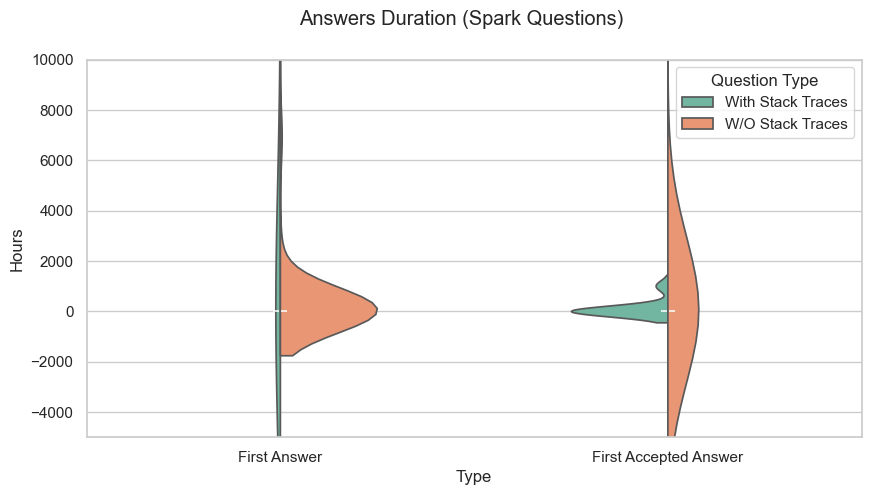

In [242]:
# Example:
sns.set_theme(style="whitegrid")

# ###################################################################################
df_1 = pd.DataFrame(columns=['Question Type', 'Hours'])
df_1['Hours'] = pd_tmp_new3_w['Duration_ans']
df_1['Question Type'] = df_1['Question Type'].apply(lambda x: "With Stack Traces")

df_2 = pd.DataFrame(columns=['Question Type', 'Hours'])
df_2['Hours'] = pd_tmp_new3_wo['Duration_ans']
df_2['Question Type'] = df_2['Question Type'].apply(lambda x: "W/O Stack Traces")

resultComment = pd.concat([df_1, df_2])
resultComment['Type'] = "First Answer"
# ###################################################################################
df_1 = pd.DataFrame(columns=['Question Type', 'Hours'])
df_1['Hours'] = pd_tmp_new3_w['Duration_acc_ans']
df_1['Question Type'] = df_1['Question Type'].apply(lambda x: "With Stack Traces")

df_2 = pd.DataFrame(columns=['Question Type', 'Hours'])
df_2['Hours'] = pd_tmp_new3_wo['Duration_acc_ans']
df_2['Question Type'] = df_2['Question Type'].apply(lambda x: "W/O Stack Traces")

resultAnswer = pd.concat([df_1, df_2])
resultAnswer['Type'] = "First Accepted Answer"
# ###################################################################################

result = pd.concat([resultComment, resultAnswer], ignore_index=True)

fig = plt.figure(figsize=(10, 5), dpi=100)

sns.violinplot(x="Type", 
               y="Hours", 
               data=result, 
               hue="Question Type", 
               palette="Set2", #colorblind
               split=True, 
               # scale="count",
               # inner="quartile",
               scale_hue=False,
               width=.5)

plt.ylim(-5000,10000)
# plt.xlim(-1,1)

fig.suptitle('Answers Duration (Spark Questions)')
# fig.suptitle('TensorFlow Questions', prop={"size":10})
# plt.gca().axes.get_xaxis().set_visible(False)
# plt.legend(loc='upper left')

plt.show()

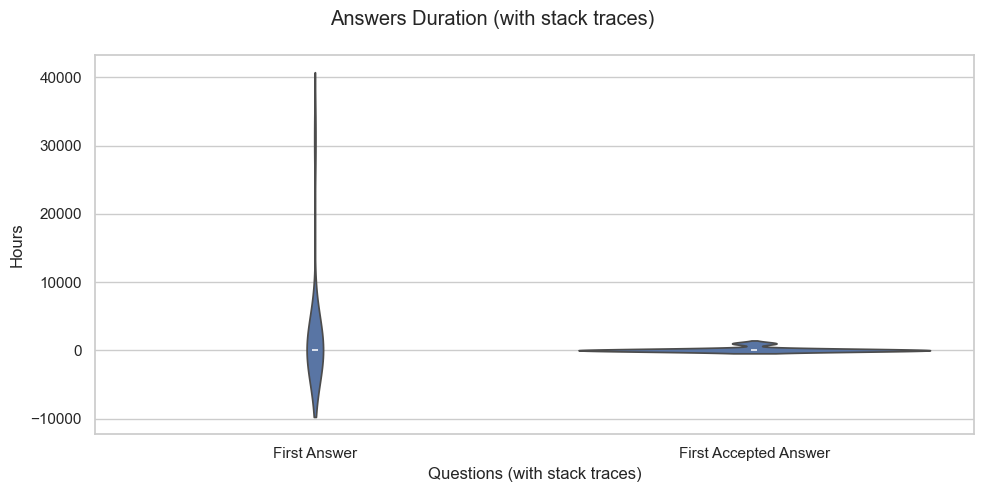

In [243]:
df_1 = pd.DataFrame(columns=['Questions (with stack traces)', 'Hours'])
df_1['Hours'] = pd_tmp_new3_w['Duration_ans']
df_1['Questions (with stack traces)'] = df_1['Questions (with stack traces)'].apply(lambda x: "First Answer")

df_2 = pd.DataFrame(columns=['Questions (with stack traces)', 'Hours'])
df_2['Hours'] = pd_tmp_new3_w['Duration_acc_ans']
df_2['Questions (with stack traces)'] = df_2['Questions (with stack traces)'].apply(lambda x: "First Accepted Answer")

result = pd.concat([df_1, df_2])

# Reset index
result.reset_index(inplace=True)

fig = plt.figure(figsize=(10, 5), dpi=100)

sns.violinplot(x=result["Questions (with stack traces)"], y=result["Hours"])

# plt.ylim(-250,500)

# fig = plt.figure(figsize=(10, 5))
# gs = fig.add_gridspec(1, 2)

# # min_ = min(min(df_status_w_stack['Duration_ans']), min(df_status_w_stack['Duration_acc_ans']))
# # max_ = max(max(df_status_w_stack['Duration_ans']), max(df_status_w_stack['Duration_acc_ans']))

# ax1 = fig.add_subplot(gs[0, 0])
# sns.violinplot(data=df_status_w_stack['Duration_ans'])
# ax1.set_xlabel("First Answer")
# ax1.set_ylabel("Day")
# # ax1 = plt.ylim(min_,max_)

# ax2 = fig.add_subplot(gs[0, 1])
# sns.violinplot(data=df_status_w_stack['Duration_acc_ans'])
# ax2.set_xlabel("First Accepted Answer")
# ax2.set_ylabel("Day")
# # ax2 = plt.ylim(min_,max_)

fig.suptitle('Answers Duration (with stack traces)')

fig.tight_layout()
plt.show()

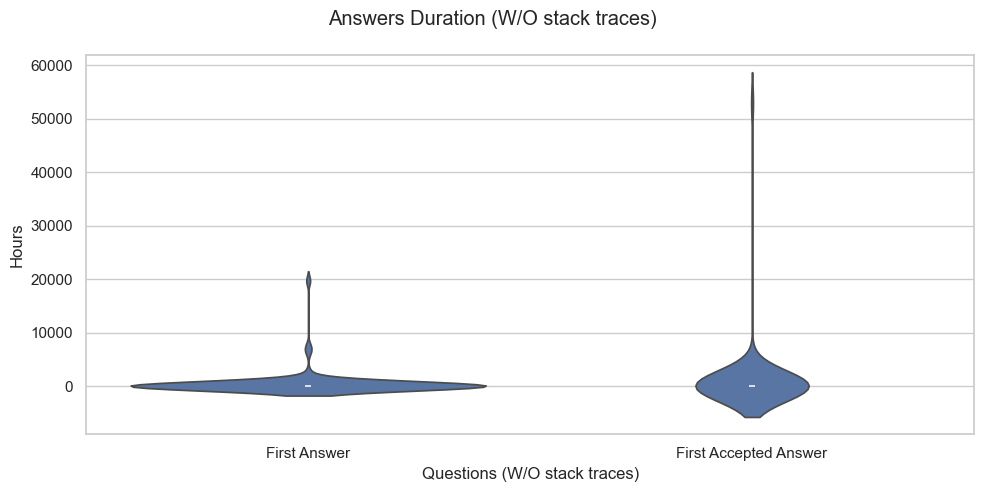

In [244]:
df_1 = pd.DataFrame(columns=['Questions (W/O stack traces)', 'Hours'])
df_1['Hours'] = pd_tmp_new3_wo['Duration_ans']
df_1['Questions (W/O stack traces)'] = df_1['Questions (W/O stack traces)'].apply(lambda x: "First Answer")

df_2 = pd.DataFrame(columns=['Questions (W/O stack traces)', 'Hours'])
df_2['Hours'] = pd_tmp_new3_wo['Duration_acc_ans']
df_2['Questions (W/O stack traces)'] = df_2['Questions (W/O stack traces)'].apply(lambda x: "First Accepted Answer")

result = pd.concat([df_1, df_2])

# Reset index
result.reset_index(inplace=True)

fig = plt.figure(figsize=(10, 5), dpi=100)

sns.violinplot(x=result["Questions (W/O stack traces)"], y=result["Hours"])

# plt.ylim(-250,500)

fig.suptitle('Answers Duration (W/O stack traces)')

fig.tight_layout()
plt.show()

## Statistics Information

In [245]:
print("Question Numbers with all ML tags: ", df.shape[0])

Question Numbers with all ML tags:  171114


In [246]:
print("Question Numbers (with Spark tags): ", df_w_sp_tags.shape[0])

Question Numbers (with Spark tags):  168


In [247]:
print("Question Numbers (without Spark tags): ", df.shape[0] - df_w_sp_tags.shape[0])

Question Numbers (without Spark tags):  170946


In [248]:
print("Spark Question Numbers (with code): ", count__question_w_code)
print("Spark Question Numbers (without code): ", count__question_wo_code)

Spark Question Numbers (with code):  152
Spark Question Numbers (without code):  16


In [249]:
print("Spark Question Numbers (with code) have stack trace: ", count_w_t)  # 40 disappeared ?!
print("Spark Question Numbers (with code) that doesn't have stack trace: ",count_wo_t)

Spark Question Numbers (with code) have stack trace:  19
Spark Question Numbers (with code) that doesn't have stack trace:  133


In [250]:
print("Spark Question Numbers (with stack trace:) on Unix based systems: ", count_unix)
print("Spark Question Numbers (with stack trace:) on Windows based systems: ", count_win)

Spark Question Numbers (with stack trace:) on Unix based systems:  18
Spark Question Numbers (with stack trace:) on Windows based systems:  1


In [251]:
line_count_unix   = 0
line_count_win    = 0
line_count_simple = 0

for tuple in df_w_sp_tags["Line_code_u_w_s"]:
    line_count_unix   += tuple[0]
    line_count_win    += tuple[1]
    line_count_simple += tuple[2]
        
print(f"The total number of line codes in the body part (w/o stack trace) is {line_count_simple}.")
print(f"The total LOC amongst stack traces is {line_count_unix} (Unix-based reports).")
print(f"The total LOC amongst stack traces is {line_count_win} (Windows-based reports).")
print(f"The total LOC amongst stack traces is {line_count_unix+line_count_win}.")

The total number of line codes in the body part (w/o stack trace) is 3593.
The total LOC amongst stack traces is 1030 (Unix-based reports).
The total LOC amongst stack traces is 20 (Windows-based reports).
The total LOC amongst stack traces is 1050.


In [252]:
print(f"We found {max(dic.values())} unique pairs in stack traces posts related to the Spark frameworks.")

We found 38 unique pairs in stack traces posts related to the Spark frameworks.


In [253]:
import math
# print("Pst: ", '{:,}'.format(df_w_sp_tags.shape[0]), "\nPst_wc: ", math.ceil(count__question_w_code*100/(count__question_w_code+count__question_wo_code)), "\nPst_woc:", 100-math.ceil(count__question_w_code*100/(count__question_w_code+count__question_wo_code)), "\nCB:", '{:,}'.format(count__num_codes), "\nCB_ws:", math.ceil(count_w_t*100/(count_w_t+count_wo_t)), "\nCB_wos:", 100-(math.ceil(count_w_t*100/(count_w_t+count_wo_t))) , "\nST:", '{:,}'.format(count_w_t), "\nU:", math.ceil(count_unix*100/count_w_t), "\nW:",100-math.ceil(count_unix*100/count_w_t))
print("Pst: ", '{:,}'.format(df_w_sp_tags.shape[0]), "\nPst_wc: ", 
      '{0:0.2f}'.format(count__question_w_code*100/(count__question_w_code+count__question_wo_code)), 
      "\nPst_woc:", '{0:0.2f}'.format(100-(count__question_w_code*100/(count__question_w_code+count__question_wo_code))), 
      "\nCB:", '{:,}'.format(count__num_codes), 
      "\nCB_ws:", '{0:0.2f}'.format(count_w_t*100/(count_w_t+count_wo_t)), 
      "\nCB_wos:", '{0:0.2f}'.format(100-(count_w_t*100/(count_w_t+count_wo_t))) , 
      "\nST:", '{:,}'.format(count_w_t), 
      "\nU:", '{0:0.2f}'.format(count_unix*100/count_w_t), 
      "\nW:",'{0:0.2f}'.format(100-(count_unix*100/count_w_t)))

print( '{:,}'.format(df_w_sp_tags.shape[0]), 
      '& {0:0.1f}\%'.format(count__question_w_code*100/(count__question_w_code+count__question_wo_code)), 
      '& {0:0.1f}\%'.format(100-(count__question_w_code*100/(count__question_w_code+count__question_wo_code))), 
      '& {:,}'.format(count__num_codes), 
      '& {0:0.1f}\%'.format(count_w_t*100/(count_w_t+count_wo_t)), 
      '& {0:0.1f}\%'.format(100-(count_w_t*100/(count_w_t+count_wo_t))) , 
      '& \multicolumn{1}{r:}{\\textbf{', count_w_t, '}}',
      '& {0:0.1f}\%'.format(count_w_t*100/df_w_sp_tags.shape[0]), 
      '& {0:0.1f}\%'.format(count_unix*100/count_w_t), 
      '& {0:0.1f}\%'.format(100-(count_unix*100/count_w_t)))

print( '{:,}'.format(df_w_sp_tags.shape[0]), 
      '& {0:0.1f}\%'.format(count__question_w_code*100/(count__question_w_code+count__question_wo_code)), 
      '& {:,}'.format(count__num_codes), 
      '& {0:0.1f}\%'.format(count_w_t*100/(count_w_t+count_wo_t)), 
      '& \multicolumn{1}{r:}{\\textbf{', count_w_t, '}}',
      '& {0:0.1f}\%'.format(count_w_t*100/df_w_sp_tags.shape[0]), 
      '& {0:0.1f}\%'.format(count_unix*100/count_w_t), 
      '& {0:0.1f}\%'.format(100-(count_unix*100/count_w_t)))


Pst:  168 
Pst_wc:  90.48 
Pst_woc: 9.52 
CB: 370 
CB_ws: 12.50 
CB_wos: 87.50 
ST: 19 
U: 94.74 
W: 5.26
168 & 90.5\% & 9.5\% & 370 & 12.5\% & 87.5\% & \multicolumn{1}{r:}{\textbf{ 19 }} & 11.3\% & 94.7\% & 5.3\%
168 & 90.5\% & 370 & 12.5\% & \multicolumn{1}{r:}{\textbf{ 19 }} & 11.3\% & 94.7\% & 5.3\%


In [254]:
print("w-ST:", '{:,}'.format(count_w_t), "wo-ST:", '{:,}'.format(count_wo_t),)
ACC_W, ACC_WO =  8 , 54
print('P1: {0:0.4f}'.format(ACC_W/count_w_t))
print('N1: {}'.format(count_w_t))
print('P2: {0:0.4f}'.format(ACC_WO/count_wo_t))
print('N2: {}'.format(count_wo_t))

w-ST: 19 wo-ST: 133
P1: 0.4211
N1: 19
P2: 0.4060
N2: 133


## Graphical Results

### LOC

/tmp/ipykernel_3092/1169558692.py:19: FutureWarning: 

The `scale_hue` parameter has been replaced and will be removed in v0.15.0. Pass `common_norm=True` for the same effect.
  sns.violinplot(x="Type",


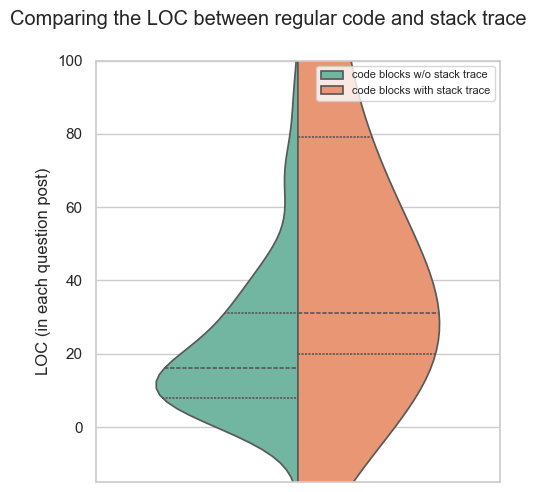

In [255]:
code_wo_trace  = df_w_sp_tags[(df_w_sp_tags.Has_code == True) & (df_w_sp_tags.Has_trace == False)].Line_code_simple_code
code_w_trace   = df_w_sp_tags[df_w_sp_tags.Has_trace == True].Line_code_win + df_w_sp_tags[df_w_sp_tags.Has_trace == True].Line_code_uix

df_1 = pd.DataFrame(columns=['Question Type', 'LOC (in each question post)'])
df_1['LOC (in each question post)'] = code_wo_trace
df_1['Question Type'] = df_1['Question Type'].apply(lambda x: "code blocks w/o stack trace")

df_2 = pd.DataFrame(columns=['Question Type', 'LOC (in each question post)'])
df_2['LOC (in each question post)'] = code_w_trace
df_2['Question Type'] = df_2['Question Type'].apply(lambda x: "code blocks with stack trace")

result = pd.concat([df_1, df_2])
result['Type'] = "Question Type"

result.to_csv('./CSV_data/plt_df_loc_sp.csv', encoding='utf-8', index=False)

fig = plt.figure(figsize=(5, 5), dpi=100)

sns.violinplot(x="Type", 
               y="LOC (in each question post)", 
               data=result, 
               hue="Question Type", 
               palette="Set2", #colorblind
               split=True, 
               # scale="count",
               inner="quartile",
               scale_hue=False,
               width=.7)

plt.ylim(-15, 100)
# plt.xlim(-1, 1)

fig.suptitle('Comparing the LOC between regular code and stack trace')

plt.gca().axes.get_xaxis().set_visible(False)
# plt.plot(legend=None)
plt.legend(loc='upper right', prop={"size":8})
fig.tight_layout()

plt.show()

### Question Length

In [256]:
df_1 = pd.DataFrame(columns=['Question Type', 'Words (in each question post)'])
df_1['Words (in each question post)'] = list_num_words_wo_tra
df_1['Question Type'] = df_1['Question Type'].apply(lambda x: "w/o stack trace")

df_2 = pd.DataFrame(columns=['Question Type', 'Words (in each question post)'])
df_2['Words (in each question post)'] = list_num_words_w_tra
df_2['Question Type'] = df_2['Question Type'].apply(lambda x: "with stack trace")

result = pd.concat([df_1, df_2])
result['Type'] = "Question Type"

In [257]:
result.to_csv('./CSV_data/plt_df_ques_len_sp.csv', encoding='utf-8', index=False)

/tmp/ipykernel_3092/3492264228.py:3: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='count'` for the same effect.
  sns.violinplot(x="Type",
/tmp/ipykernel_3092/3492264228.py:3: FutureWarning: 

The `scale_hue` parameter has been replaced and will be removed in v0.15.0. Pass `common_norm=True` for the same effect.
  sns.violinplot(x="Type",


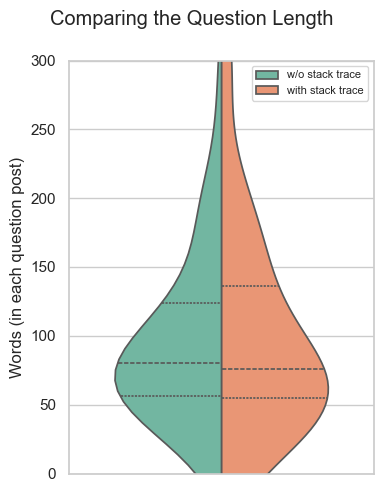

In [258]:
fig = plt.figure(figsize=(4, 5), dpi=100)

sns.violinplot(x="Type", 
               y="Words (in each question post)", 
               data=result, 
               hue="Question Type", 
               palette="Set2", #colorblind
               split=True, 
               scale="count",
               inner="quartile",
               scale_hue=False,
               width=.7)

plt.ylim(0, 300)
# plt.xlim(-1, 1)

fig.suptitle('Comparing the Question Length')

plt.gca().axes.get_xaxis().set_visible(False)
# plt.plot(legend=None)
plt.legend(loc='upper right', prop={"size":8})
fig.tight_layout()

plt.show()

### Plotting Score, View, Answer, Comment Counts 

In [259]:
df_status_w_stack.to_csv('./CSV_data/plt_df_sp_w_table3_stack.csv', encoding='utf-8')
df_status_wo_stack.to_csv('./CSV_data/plt_df_sp_wo_table3_stack.csv', encoding='utf-8')

In [260]:
def get_sturges_rule_number(n_obser: int) -> int:
    '''
    Sturges’ Rule is the most common method for determining the optimal number of bins.

    Parameters:
    ----------
    n_obser : int
        The total number of observations in the dataset.

    Returns:
    ----------
    Use ⌈ ⌉ for returning a value: Symbols that mean “ceiling” – i.e. round the answer up to
    the nearest integer.
    '''
    # return round(1 + math.log2(n_obser))
    return round(np.ceil(1 + (3.322 * np.log10(n_obser))))

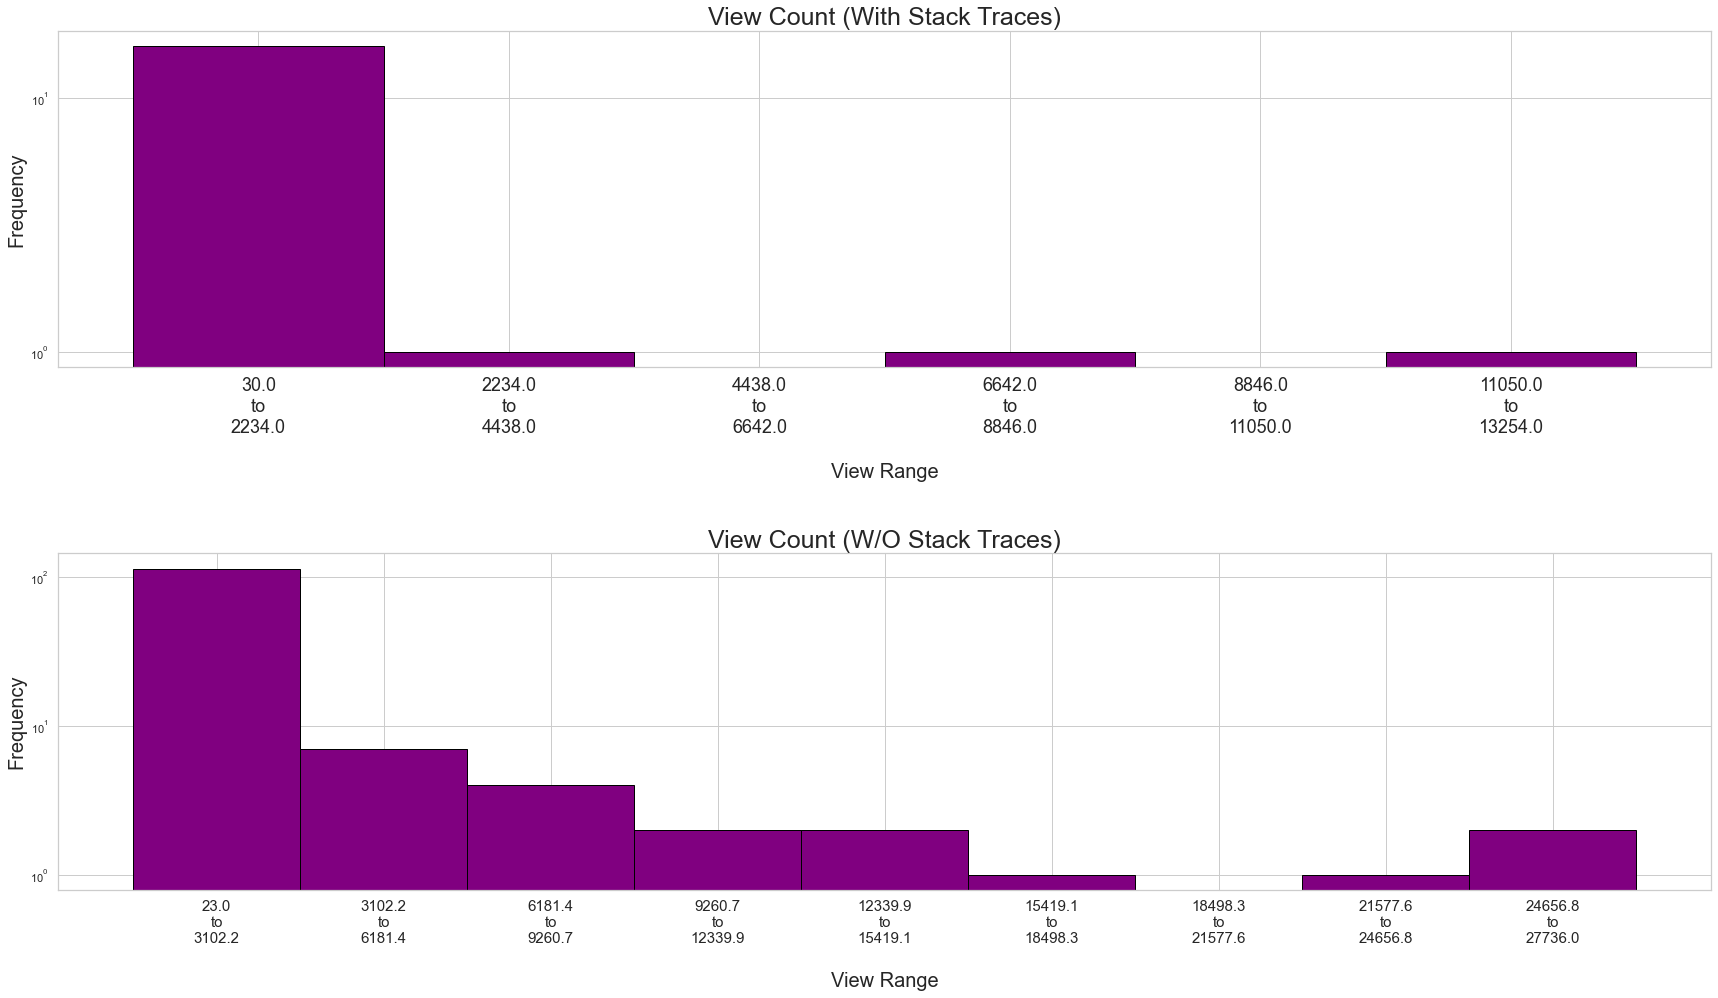

In [261]:
plt.figure(figsize=[25,15])
plt.subplot(211)

plt.title('View Count (With Stack Traces)', fontsize=25)
plt.xlabel('\nView Range', fontsize=20)
plt.ylabel('Frequency', fontsize=20)

n_bins = get_sturges_rule_number(len(df_status_w_stack['View_count']))

n, bins, patches = plt.hist(df_status_w_stack['View_count'], 
                             bins=n_bins, 
                             log=True, 
                             align='right', 
                             color='purple', 
                             edgecolor='black')

# define minor ticks and draw a grid with them
minor_locator = AutoMinorLocator(2)
plt.gca().xaxis.set_minor_locator(minor_locator)
# plt.grid(False)
# plt.grid(which='minor', color='white', lw = 0.5)
# x ticks
xticks = [(bins[idx+1] + value)/2 for idx, value in enumerate(bins[:-1])]
dist = (xticks[1] - xticks[0])/2
xticks = [e+dist for e in xticks]
xticks_labels = [ "{:.1f}\nto\n{:.1f}".format(value, bins[idx+1]) for idx, value in enumerate(bins[:-1])]
plt.xticks(xticks, labels = xticks_labels, fontsize=18)


plt.subplot(212)

plt.title('View Count (W/O Stack Traces)', fontsize=25)
plt.xlabel('\nView Range', fontsize=20)
plt.ylabel('Frequency', fontsize=20)

n_bins = get_sturges_rule_number(len(df_status_wo_stack['View_count']))

n, bins, patches = plt.hist(df_status_wo_stack['View_count'], 
                             bins=n_bins, 
                             log=True, 
                             align='right', 
                             color='purple', 
                             edgecolor='black')

# define minor ticks and draw a grid with them
minor_locator = AutoMinorLocator(2)
plt.gca().xaxis.set_minor_locator(minor_locator)
# plt.grid(which='minor', color='white', lw = 0.5)
# x ticks
xticks = [(bins[idx+1] + value)/2 for idx, value in enumerate(bins[:-1])]
dist = (xticks[1] - xticks[0])/2
xticks = [e+dist for e in xticks]
xticks_labels = [ "{:.1f}\nto\n{:.1f}".format(value, bins[idx+1]) for idx, value in enumerate(bins[:-1])]
plt.xticks(xticks, labels = xticks_labels, fontsize=15)

plt.tight_layout(pad=4.0)
plt.show()

/tmp/ipykernel_3092/944062759.py:14: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='count'` for the same effect.
  sns.violinplot(x="Type",
/tmp/ipykernel_3092/944062759.py:14: FutureWarning: 

The `scale_hue` parameter has been replaced and will be removed in v0.15.0. Pass `common_norm=True` for the same effect.
  sns.violinplot(x="Type",


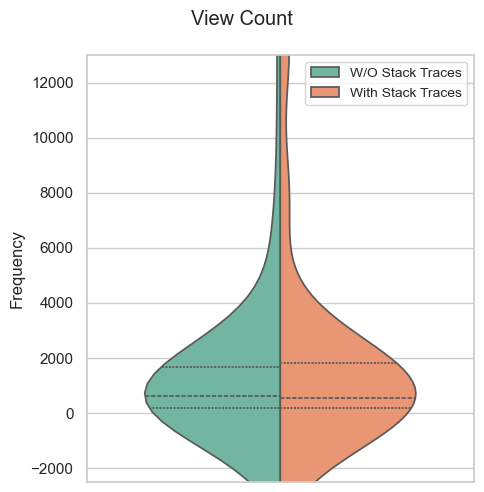

In [262]:
df_1 = pd.DataFrame(columns=['Question Type', 'Frequency'])
df_1['Frequency'] = df_status_wo_stack['View_count']
df_1['Question Type'] = df_1['Question Type'].apply(lambda x: "W/O Stack Traces")

df_2 = pd.DataFrame(columns=['Question Type', 'Frequency'])
df_2['Frequency'] = df_status_w_stack['View_count']
df_2['Question Type'] = df_2['Question Type'].apply(lambda x: "With Stack Traces")

result = pd.concat([df_1, df_2])
result['Type'] = "Question Type"

fig = plt.figure(figsize=(5, 5), dpi=100)

sns.violinplot(x="Type", 
               y="Frequency", 
               data=result, 
               hue="Question Type", 
               palette="Set2", #colorblind
               split=True, 
               scale="count",
               inner="quartile",
               scale_hue=False,
               width=.7)

plt.ylim(-2500,13000)
# plt.xlim(-1,1)

fig.suptitle('View Count')
plt.gca().axes.get_xaxis().set_visible(False)
# plt.plot(legend=None)
plt.legend(loc='upper right', prop={"size":10})
fig.tight_layout()
plt.show()

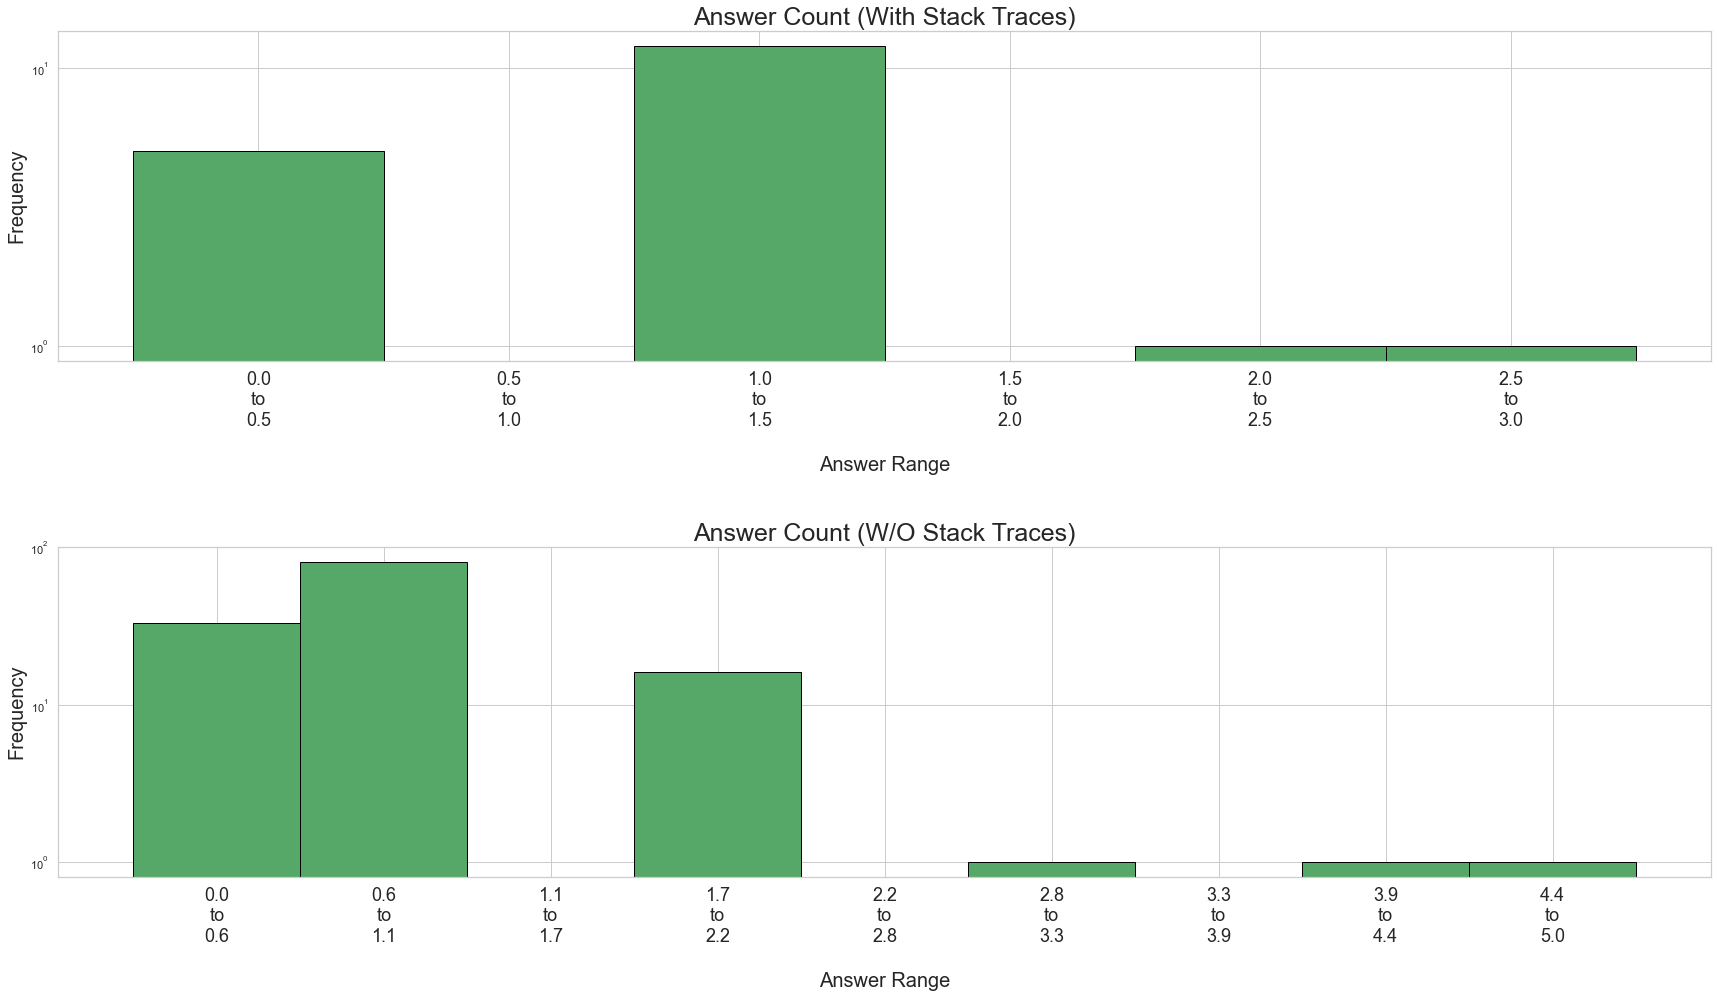

In [263]:
plt.figure(figsize=[25,15])

plt.subplot(211)

plt.title('Answer Count (With Stack Traces)', fontsize=25)
plt.xlabel('\nAnswer Range', fontsize=20)
plt.ylabel('Frequency', fontsize=20)

n_bins = get_sturges_rule_number(len(df_status_w_stack['Answer_count']))

n, bins, patches = plt.hist(df_status_w_stack['Answer_count'], 
                             bins=n_bins, 
                             log=True, 
                             align='right', 
                             color='g', 
                             edgecolor='black')

# define minor ticks and draw a grid with them
minor_locator = AutoMinorLocator(2)
plt.gca().xaxis.set_minor_locator(minor_locator)
# plt.grid(which='minor', color='white', lw = 0.5)
# x ticks
xticks = [(bins[idx+1] + value)/2 for idx, value in enumerate(bins[:-1])]
dist = (xticks[1] - xticks[0])/2
xticks = [e+dist for e in xticks]
xticks_labels = [ "{:.1f}\nto\n{:.1f}".format(value, bins[idx+1]) for idx, value in enumerate(bins[:-1])]
plt.xticks(xticks, labels = xticks_labels, fontsize=18)

plt.subplot(212)

plt.title('Answer Count (W/O Stack Traces)', fontsize=25)
plt.xlabel('\nAnswer Range', fontsize=20)
plt.ylabel('Frequency', fontsize=20)

n_bins = get_sturges_rule_number(len(df_status_wo_stack['Answer_count']))

n, bins, patches = plt.hist(df_status_wo_stack['Answer_count'], 
                             bins=n_bins, 
                             log=True, 
                             align='right', 
                             color='g', 
                             edgecolor='black')

# define minor ticks and draw a grid with them
minor_locator = AutoMinorLocator(2)
plt.gca().xaxis.set_minor_locator(minor_locator)
# plt.grid(which='minor', color='white', lw = 0.5)
# x ticks
xticks = [(bins[idx+1] + value)/2 for idx, value in enumerate(bins[:-1])]
dist = (xticks[1] - xticks[0])/2
xticks = [e+dist for e in xticks]
xticks_labels = [ "{:.1f}\nto\n{:.1f}".format(value, bins[idx+1]) for idx, value in enumerate(bins[:-1])]
plt.xticks(xticks, labels = xticks_labels, fontsize=18)

plt.tight_layout(pad=4.0)
plt.show()

/tmp/ipykernel_3092/3175706676.py:15: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='count'` for the same effect.
  sns.violinplot(x="Type",
/tmp/ipykernel_3092/3175706676.py:15: FutureWarning: 

The `scale_hue` parameter has been replaced and will be removed in v0.15.0. Pass `common_norm=True` for the same effect.
  sns.violinplot(x="Type",


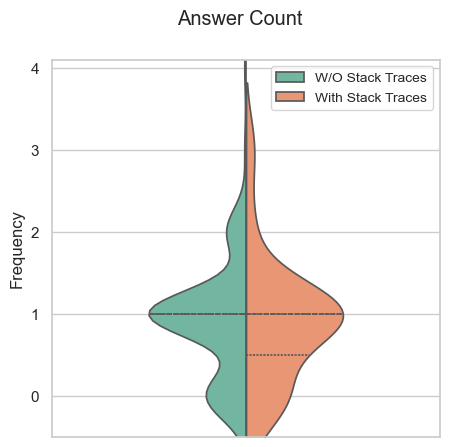

In [264]:
sns.set_theme(style="whitegrid")
df_1 = pd.DataFrame(columns=['Question Type', 'Frequency'])
df_1['Frequency'] = df_status_wo_stack['Answer_count']
df_1['Question Type'] = df_1['Question Type'].apply(lambda x: "W/O Stack Traces")

df_2 = pd.DataFrame(columns=['Question Type', 'Frequency'])
df_2['Frequency'] = df_status_w_stack['Answer_count']
df_2['Question Type'] = df_2['Question Type'].apply(lambda x: "With Stack Traces")

result = pd.concat([df_1, df_2])
result['Type'] = "Question Type"

fig = plt.figure(figsize=(5, 5), dpi=100)

sns.violinplot(x="Type", 
               y="Frequency", 
               data=result, 
               hue="Question Type", 
               palette="Set2", #colorblind
               split=True, 
               scale="count",
               inner="quartile",
               scale_hue=False,
               width=.5)

plt.ylim(-.5,4.1)
# plt.xlim(-1,1)

fig.suptitle('Answer Count')
plt.gca().axes.get_xaxis().set_visible(False)
# plt.plot(legend=None)
plt.legend(loc='upper right', prop={"size":10})

plt.show()

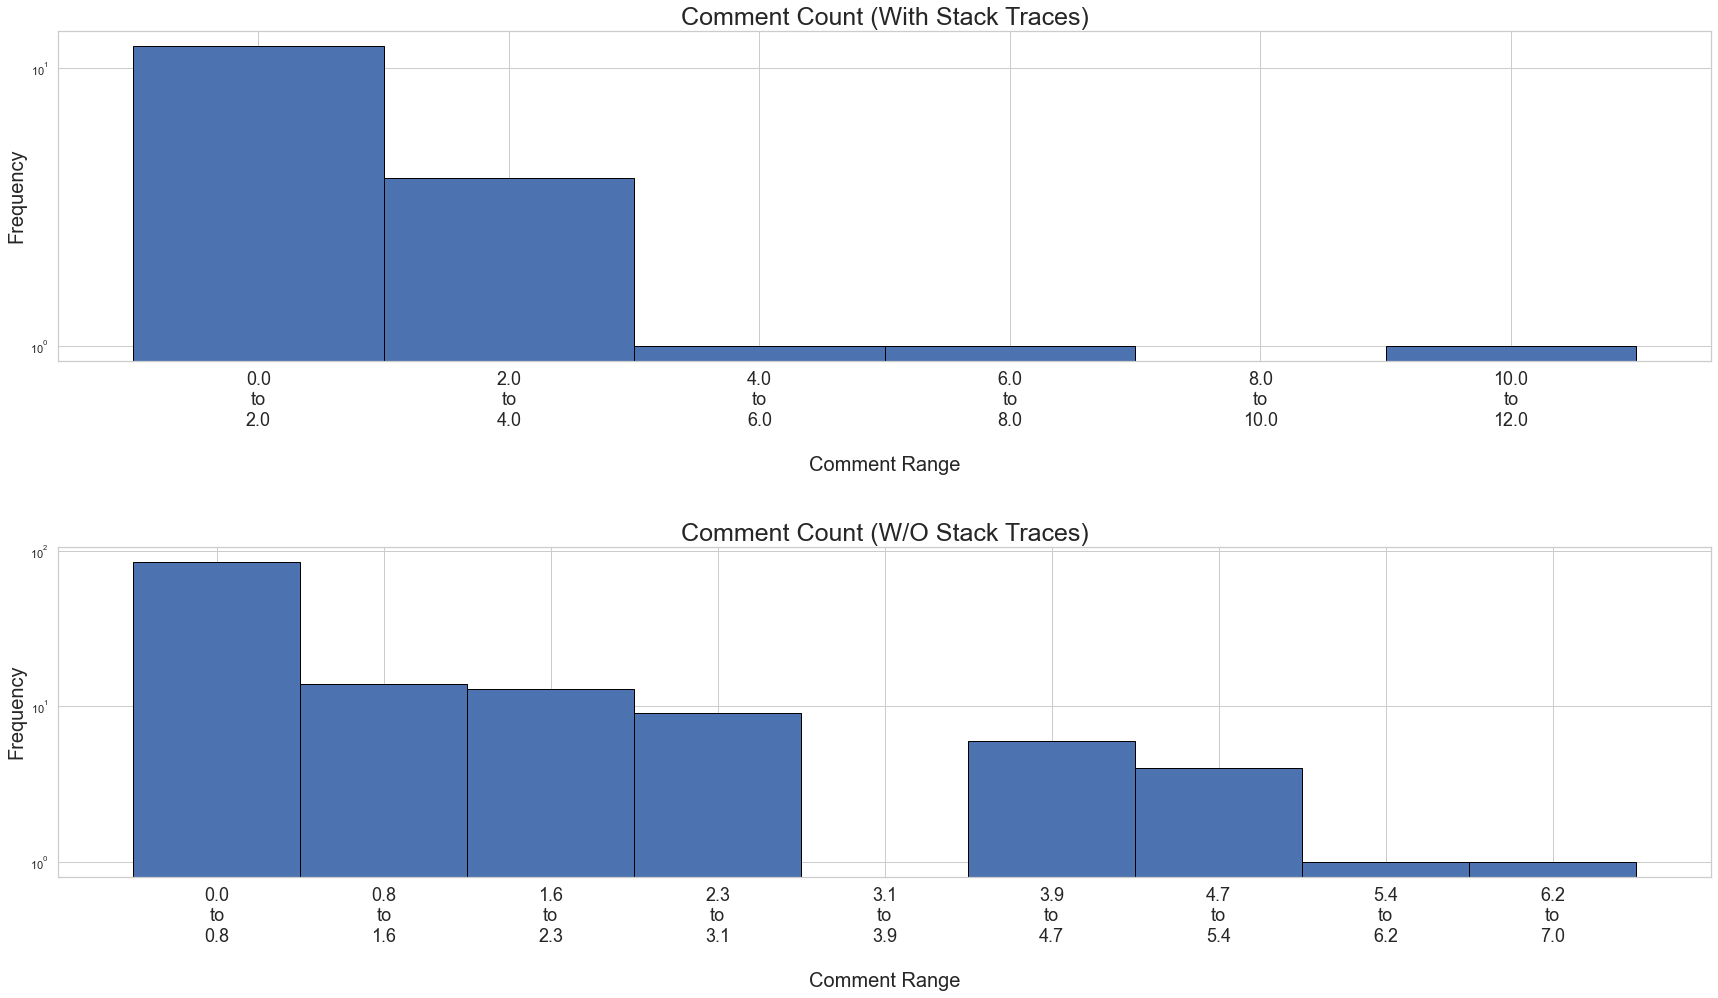

In [265]:
plt.figure(figsize=[25,15])

plt.subplot(211)

plt.title('Comment Count (With Stack Traces)', fontsize=25)
plt.xlabel('\nComment Range', fontsize=20)
plt.ylabel('Frequency', fontsize=20)

n_bins = get_sturges_rule_number(len(df_status_w_stack['Comment_count']))

n, bins, patches = plt.hist(df_status_w_stack['Comment_count'], 
                             bins=n_bins, 
                             log=True, 
                             align='right', 
                             color='b', 
                             edgecolor='black')

# define minor ticks and draw a grid with them
minor_locator = AutoMinorLocator(2)
plt.gca().xaxis.set_minor_locator(minor_locator)
# plt.grid(which='minor', color='white', lw = 0.5)
# x ticks
xticks = [(bins[idx+1] + value)/2 for idx, value in enumerate(bins[:-1])]
dist = (xticks[1] - xticks[0])/2
xticks = [e+dist for e in xticks]
xticks_labels = [ "{:.1f}\nto\n{:.1f}".format(value, bins[idx+1]) for idx, value in enumerate(bins[:-1])]
plt.xticks(xticks, labels = xticks_labels, fontsize=18)

plt.subplot(212)

plt.title('Comment Count (W/O Stack Traces)', fontsize=25)
plt.xlabel('\nComment Range', fontsize=20)
plt.ylabel('Frequency', fontsize=20)

n_bins = get_sturges_rule_number(len(df_status_wo_stack['Comment_count']))

n, bins, patches = plt.hist(df_status_wo_stack['Comment_count'], 
                             bins=n_bins, 
                             log=True, 
                             align='right', 
                             color='b', 
                             edgecolor='black')

# define minor ticks and draw a grid with them
minor_locator = AutoMinorLocator(2)
plt.gca().xaxis.set_minor_locator(minor_locator)
# plt.grid(which='minor', color='white', lw = 0.5)
# x ticks
xticks = [(bins[idx+1] + value)/2 for idx, value in enumerate(bins[:-1])]
dist = (xticks[1] - xticks[0])/2
xticks = [e+dist for e in xticks]
xticks_labels = [ "{:.1f}\nto\n{:.1f}".format(value, bins[idx+1]) for idx, value in enumerate(bins[:-1])]
plt.xticks(xticks, labels = xticks_labels, fontsize=18)

plt.tight_layout(pad=4.0)

plt.show()

/tmp/ipykernel_3092/273534430.py:14: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='count'` for the same effect.
  sns.violinplot(x="Type",
/tmp/ipykernel_3092/273534430.py:14: FutureWarning: 

The `scale_hue` parameter has been replaced and will be removed in v0.15.0. Pass `common_norm=True` for the same effect.
  sns.violinplot(x="Type",


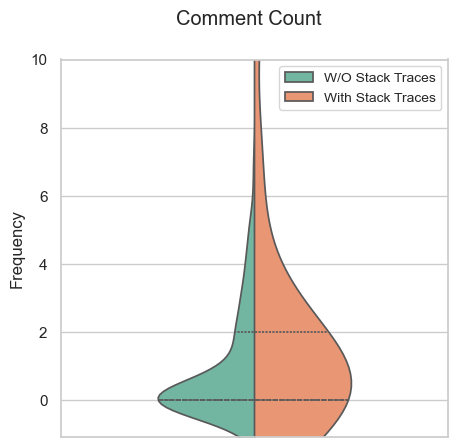

In [266]:
df_1 = pd.DataFrame(columns=['Question Type', 'Frequency'])
df_1['Frequency'] = df_status_wo_stack['Comment_count']
df_1['Question Type'] = df_1['Question Type'].apply(lambda x: "W/O Stack Traces")

df_2 = pd.DataFrame(columns=['Question Type', 'Frequency'])
df_2['Frequency'] = df_status_w_stack['Comment_count']
df_2['Question Type'] = df_2['Question Type'].apply(lambda x: "With Stack Traces")

result = pd.concat([df_1, df_2])
result['Type'] = "Question Type"

fig = plt.figure(figsize=(5, 5), dpi=100)

sns.violinplot(x="Type", 
               y="Frequency", 
               data=result, 
               hue="Question Type", 
               palette="Set2", #colorblind
               split=True, 
               scale="count",
               inner="quartile",
               scale_hue=False,
               width=.5)

plt.ylim(-1.1,10)
# plt.xlim(-1,1)

fig.suptitle('Comment Count')
plt.gca().axes.get_xaxis().set_visible(False)
# plt.plot(legend=None)
plt.legend(loc='upper right', prop={"size":10})

plt.show()

/tmp/ipykernel_3092/4046326228.py:53: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='count'` for the same effect.
  sns.violinplot(x="Type",
/tmp/ipykernel_3092/4046326228.py:53: FutureWarning: 

The `scale_hue` parameter has been replaced and will be removed in v0.15.0. Pass `common_norm=True` for the same effect.
  sns.violinplot(x="Type",


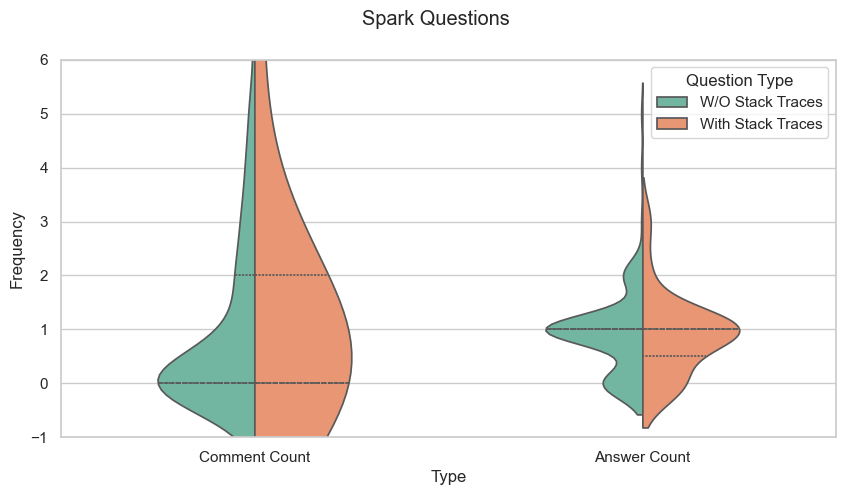

In [267]:
# Example:

sns.set_theme(style="whitegrid")
# ###################################################################################
df_1 = pd.DataFrame(columns=['Question Type', 'Frequency'])
df_1['Frequency'] = df_status_wo_stack['Comment_count']
df_1['Question Type'] = df_1['Question Type'].apply(lambda x: "W/O Stack Traces")

df_2 = pd.DataFrame(columns=['Question Type', 'Frequency'])
df_2['Frequency'] = df_status_w_stack['Comment_count']
df_2['Question Type'] = df_2['Question Type'].apply(lambda x: "With Stack Traces")

resultComment = pd.concat([df_1, df_2])
resultComment['Type'] = "Comment Count"
# ###################################################################################
df_1 = pd.DataFrame(columns=['Question Type', 'Frequency'])
df_1['Frequency'] = df_status_wo_stack['Answer_count']
df_1['Question Type'] = df_1['Question Type'].apply(lambda x: "W/O Stack Traces")

df_2 = pd.DataFrame(columns=['Question Type', 'Frequency'])
df_2['Frequency'] = df_status_w_stack['Answer_count']
df_2['Question Type'] = df_2['Question Type'].apply(lambda x: "With Stack Traces")

resultAnswer = pd.concat([df_1, df_2])
resultAnswer['Type'] = "Answer Count"
# ###################################################################################
# df_1 = pd.DataFrame(columns=['Question Type', 'Frequency'])
# df_1['Frequency'] = df_status_wo_stack['View_count']
# df_1['Question Type'] = df_1['Question Type'].apply(lambda x: "W/O Stack Traces")

# df_2 = pd.DataFrame(columns=['Question Type', 'Frequency'])
# df_2['Frequency'] = df_status_w_stack['View_count']
# df_2['Question Type'] = df_2['Question Type'].apply(lambda x: "With Stack Traces")

# resultView = pd.concat([df_1, df_2])
# resultView['Type'] = "View Count"
# ###################################################################################
# df_1 = pd.DataFrame(columns=['Question Type', 'Frequency'])
# df_1['Frequency'] = df_status_wo_stack['Score']
# df_1['Question Type'] = df_1['Question Type'].apply(lambda x: "W/O Stack Traces")

# df_2 = pd.DataFrame(columns=['Question Type', 'Frequency'])
# df_2['Frequency'] = df_status_w_stack['Score']
# df_2['Question Type'] = df_2['Question Type'].apply(lambda x: "With Stack Traces")

# resultScore = pd.concat([df_1, df_2])
# resultScore['Type'] = "Score Count"
# ###################################################################################
result = pd.concat([resultComment, resultAnswer], ignore_index=True)

fig = plt.figure(figsize=(10, 5), dpi=100)

sns.violinplot(x="Type", 
               y="Frequency", 
               data=result, 
               hue="Question Type", 
               palette="Set2", #colorblind
               split=True, 
               scale="count",
               inner="quartile",
               scale_hue=False,
               width=.5)

plt.ylim(-1,6)
# plt.xlim(-1,1)

fig.suptitle('Spark Questions')
# fig.suptitle('TensorFlow Questions', prop={"size":10})
# plt.gca().axes.get_xaxis().set_visible(False)
# plt.legend(loc='upper left')

plt.show()

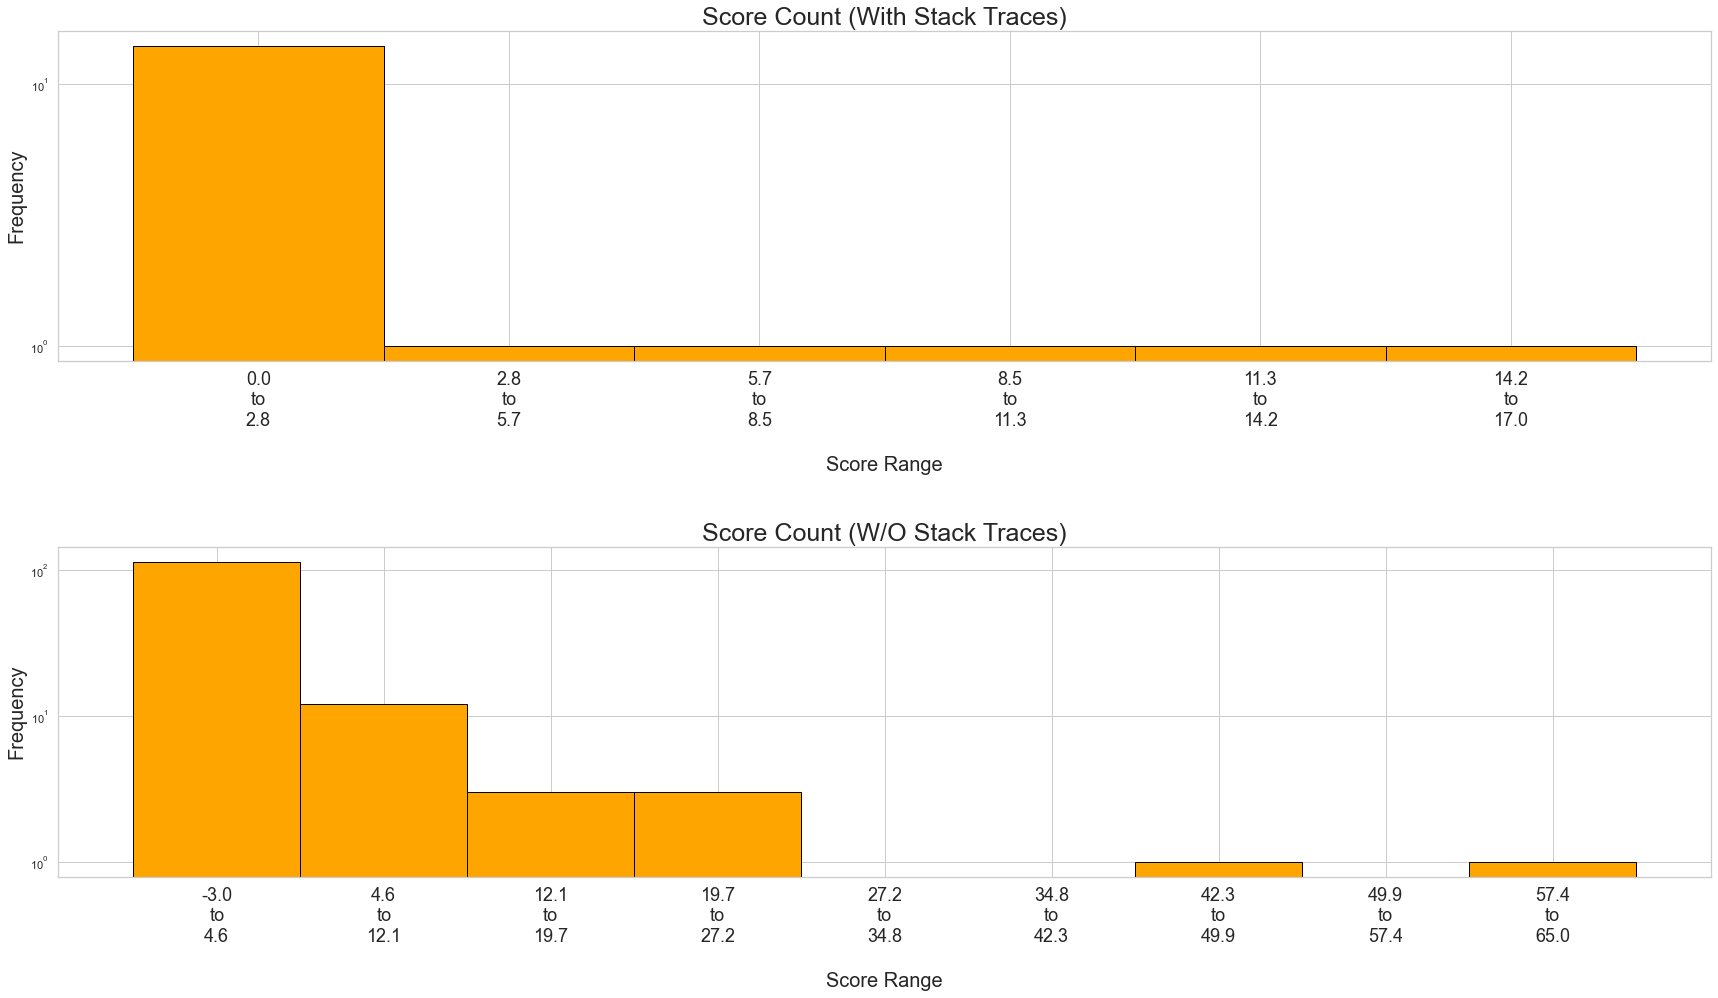

In [268]:
plt.figure(figsize=[25,15])

plt.subplot(211)

plt.title('Score Count (With Stack Traces)', fontsize=25)
plt.xlabel('\nScore Range', fontsize=20)
plt.ylabel('Frequency', fontsize=20)

n_bins = get_sturges_rule_number(len(df_status_w_stack['Score']))

n, bins, patches = plt.hist(df_status_w_stack['Score'], 
                             bins=n_bins, 
                             log=True, 
                             align='right', 
                             color='orange', 
                             edgecolor='black')

# define minor ticks and draw a grid with them
minor_locator = AutoMinorLocator(2)
plt.gca().xaxis.set_minor_locator(minor_locator)
# plt.grid(which='minor', color='white', lw = 0.5)
# x ticks
xticks = [(bins[idx+1] + value)/2 for idx, value in enumerate(bins[:-1])]
dist = (xticks[1] - xticks[0])/2
xticks = [e+dist for e in xticks]
xticks_labels = [ "{:.1f}\nto\n{:.1f}".format(value, bins[idx+1]) for idx, value in enumerate(bins[:-1])]
plt.xticks(xticks, labels = xticks_labels, fontsize=18)

plt.subplot(212)

plt.title('Score Count (W/O Stack Traces)', fontsize=25)
plt.xlabel('\nScore Range', fontsize=20)
plt.ylabel('Frequency', fontsize=20)

n_bins = get_sturges_rule_number(len(df_status_wo_stack['Score']))

n, bins, patches = plt.hist(df_status_wo_stack['Score'], 
                             bins=n_bins, 
                             log=True, 
                             align='right', 
                             color='orange', 
                             edgecolor='black')

# define minor ticks and draw a grid with them
minor_locator = AutoMinorLocator(2)
plt.gca().xaxis.set_minor_locator(minor_locator)
# plt.grid(which='minor', color='white', lw = 0.5)
# x ticks
xticks = [(bins[idx+1] + value)/2 for idx, value in enumerate(bins[:-1])]
dist = (xticks[1] - xticks[0])/2
xticks = [e+dist for e in xticks]
xticks_labels = [ "{:.1f}\nto\n{:.1f}".format(value, bins[idx+1]) for idx, value in enumerate(bins[:-1])]
plt.xticks(xticks, labels = xticks_labels, fontsize=18)

plt.tight_layout(pad=4.0)
plt.show()

/tmp/ipykernel_3092/3837863241.py:14: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='count'` for the same effect.
  sns.violinplot(x="Type",
/tmp/ipykernel_3092/3837863241.py:14: FutureWarning: 

The `scale_hue` parameter has been replaced and will be removed in v0.15.0. Pass `common_norm=True` for the same effect.
  sns.violinplot(x="Type",


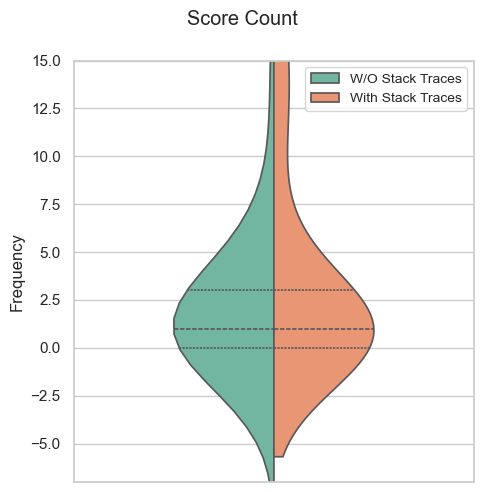

In [269]:
df_1 = pd.DataFrame(columns=['Question Type', 'Frequency'])
df_1['Frequency'] = df_status_wo_stack['Score']
df_1['Question Type'] = df_1['Question Type'].apply(lambda x: "W/O Stack Traces")

df_2 = pd.DataFrame(columns=['Question Type', 'Frequency'])
df_2['Frequency'] = df_status_w_stack['Score']
df_2['Question Type'] = df_2['Question Type'].apply(lambda x: "With Stack Traces")

result = pd.concat([df_1, df_2])
result['Type'] = "Question Type"

fig = plt.figure(figsize=(5, 5), dpi=100)

sns.violinplot(x="Type", 
               y="Frequency", 
               data=result, 
               hue="Question Type", 
               palette="Set2", #colorblind
               split=True, 
               scale="count",
               inner="quartile",
               scale_hue=False,
               width=.5)

plt.ylim(-7,15)
# plt.xlim(-1,1)

fig.suptitle('Score Count')
plt.gca().axes.get_xaxis().set_visible(False)
# plt.plot(legend=None)
plt.legend(loc='upper right', prop={"size":10})
fig.tight_layout()
plt.show()

In [270]:
# facecolor = '#EAEAEA'
# color_bars = '#3475D0'
# txt_color1 = '#252525'
# txt_color2 = '#004C74'
# fig, ax = plt.subplots(1, figsize=(20,6), facecolor=facecolor)
# ax.set_facecolor(facecolor)
# n, bins, patches = plt.hist(df_status_w_stack['Score'], 
#                              bins=n_bins, color=color_bars, log=True)
# #grid
# minor_locator = AutoMinorLocator(2)
# plt.gca().xaxis.set_minor_locator(minor_locator)
# # plt.grid(which='minor', color=facecolor, lw = 0.5)
# xticks = [(bins[idx+1] + value)/2 for idx, value in enumerate(bins[:-1])]
# xticks_labels = [ "{:.0f}-{:.0f}".format(value, bins[idx+1]) for idx, value in enumerate(bins[:-1])]
# plt.xticks(xticks, labels=xticks_labels, c=txt_color1, fontsize=13)

# # remove major and minor ticks from the x axis, but keep the labels
# ax.tick_params(axis='x', which='both',length=0)
# # remove y ticks
# plt.yticks([])

# # Hide the right and top spines
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# for idx, value in enumerate(n):
#     if value > 0:
#         plt.text(xticks[idx], value+5, int(value), ha='center', fontsize=16, c=txt_color1)

# plt.title('\nTensorFlow - Score Count\n', loc = 'center', fontsize = 20, c=txt_color1)
# plt.xlabel('\nScore Range', c=txt_color2, fontsize=14)
# plt.ylabel('\nFrequency', c=txt_color2, fontsize=14)
# plt.tight_layout()
# # plt.savefig('costs.png', facecolor=facecolor)

In [271]:
# import datetime

# flag = 0
# fr_time = pd.to_datetime(datetime.datetime.now())
# acc_time = pd.to_datetime(datetime.datetime.now())

# for answer in tt:
#     anwer_time = pd.to_datetime(answer[1])
#     if flag == 0:
#         fr_time = anwer_time
#         flag = 1
    
#     if fr_time > anwer_time:
#         fr_time = anwer_time
    
#     if int(60535969) == answer[0]:
#         acc_time = anwer_time

# print(fr_time)
# print(acc_time)

In [272]:
# fig = plt.figure(figsize=(10, 5))
# gs = fig.add_gridspec(1, 2)

# min_ = min(min(df_status_w_stack['View_count']), min(df_status_wo_stack['View_count']))
# max_ = max(max(df_status_w_stack['View_count']), max(df_status_wo_stack['View_count']))

# ax1 = fig.add_subplot(gs[0, 0])
# sns.violinplot(data=df_status_w_stack['View_count'])
# ax1.set_xlabel("with Stack Traces")
# ax1.set_ylabel("Frequency")
# ax1 = plt.ylim(min_,max_)

# ax2 = fig.add_subplot(gs[0, 1])
# sns.violinplot(data=df_status_wo_stack['View_count'])
# ax2.set_xlabel("w/o Stack Traces")
# ax2.set_ylabel("Frequency")
# ax2 = plt.ylim(min_,max_)

In [273]:
result2, result_remove2 = CloConSeqGen_v3(dic_count, threshold=2)

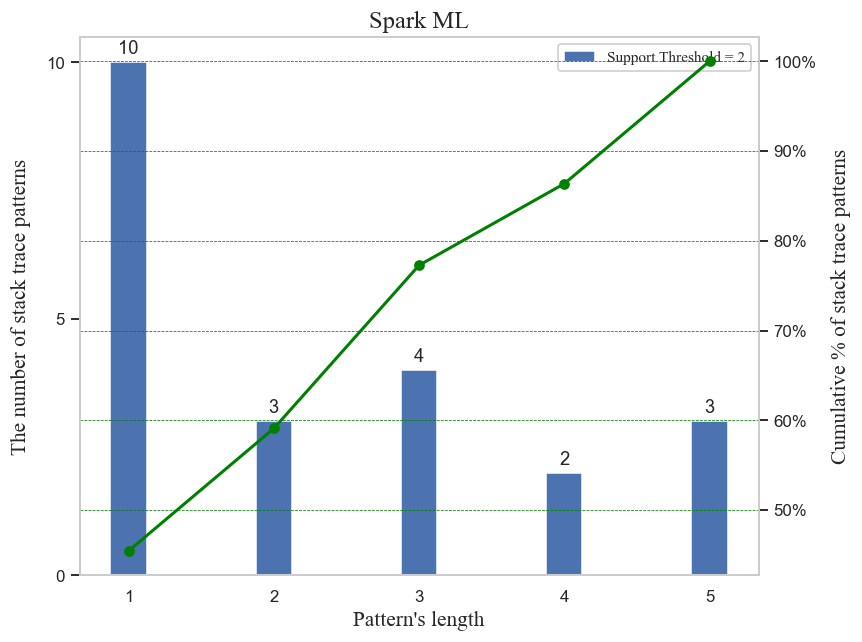

In [274]:
# win_size_list_1 = []
# for element in result:
#     win_size_list_1.append(len(element[1]))
# win_size_set_1 = set(win_size_list_1)
# cnt_1=collections.Counter(win_size_list_1)
# # print("cnt1:", cnt_1, len(result), sum(cnt_1.values()))

win_size_list_2 = []
for element in result2:
    win_size_list_2.append(len(element[1]))
win_size_set_2 = set(win_size_list_2)
cnt_2=collections.Counter(win_size_list_2)
# print("cnt2:", cnt_2, len(result2), sum(cnt_2.values()))

# cnt_2 = dict(sorted(cnt_2.items()))
# comulative_y = np.cumsum(list(counter.values()))

x = np.array(sorted(cnt_2.keys())) # the label locations
# x = [int(e) for e in x]
width = 0.25  # the width of the bars

# for length in x:
#     if not length in cnt_2.keys():
#         cnt_2[length] = 0

# y-axis
# patters_num_1 = []
# for key in sorted(cnt_1.keys()) :
#     # print(key , " :: " , cnt_1[key])
#     patters_num_1.append(cnt_1[key])

patters_num_2 = []
for key in sorted(cnt_2.keys()) :
    # print(key , " :: " , cnt_1[key])
    patters_num_2.append(cnt_2[key])

fig, ax = plt.subplots(figsize=(8, 6), dpi=110)

x = [str(item) for item in x] 

# rects1 = ax.bar(x - width/2, patters_num_1, width, label='Support Threshold = 1')
rects2 = ax.bar(x, patters_num_2, width, label='Support Threshold = 2')

ax.set_title('Spark ML', fontname="Times New Roman", fontsize=16)
ax.legend(prop={'family':'Times New Roman', 'size':10}, facecolor='w', framealpha=1)

ax.set_xlabel('Pattern\'s length', fontname="Times New Roman", fontsize=14)
ax.set_xticks(x)

ax.set_ylabel('The number of stack trace patterns', labelpad=10, fontname="Times New Roman", fontsize=14)
ax.set_yticks(range(0, max(patters_num_2)+1, 5))

# ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

win_size_list = []
for element in result2:
    win_size_list.append(len(element[1]))
win_size_set = set(win_size_list)
counter=collections.Counter(win_size_list)

counter = dict(sorted(counter.items()))
comulative_y = np.cumsum(list(counter.values()))

per_list_patterns = []
for element in comulative_y:
    per_list_patterns.append((element*100)/comulative_y[-1])

x2 = counter.keys() 
x2 = [str(item) for item in x2] 
    
ax2 = ax.twinx()
ax2.plot(x2, per_list_patterns, '-o', color='green', linewidth=2)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
ax2.set_ylabel('Cumulative % of stack trace patterns', labelpad=10, fontname="Times New Roman", fontsize=14)

ax2.grid(axis = 'y', color='green', linestyle='--', linewidth=0.5)
# ax2.grid(False)
ax.grid(False)

fig.tight_layout()
# plt.savefig('sp_le_rq1.pdf')
plt.show()

In [275]:
plt_dic_sp_plength_rq1 = {"x":x, "y2":per_list_patterns, "y1": patters_num_2}
pickle.dump(plt_dic_sp_plength_rq1, open("./Pickle_data/plt_dic_sp_plength_rq1.p", "wb"))

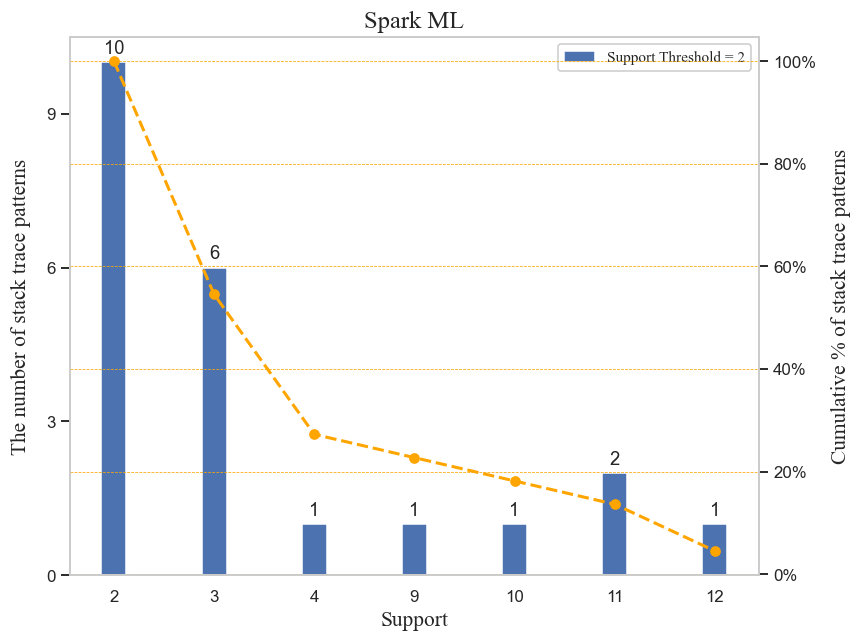

In [276]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "sans-serif"

result2, result_remove2 = CloConSeqGen_v3(dic_count, threshold=2)
      
sorted_result2 = sorted(result2, key=lambda tup: tup[0])

sup_x = sorted(set([element[0] for element in result2]))

len_sup_y = []
lst_supp = [y[0] for y in sorted_result2]

cnt = collections.Counter(lst_supp)
for item in sup_x:
    len_sup_y.append(cnt[item])
    
comulative_y = np.cumsum(list(cnt.values()))

per_len_sup_y = []
for element in comulative_y:
    per_len_sup_y.append((element*100)/comulative_y[-1])
per_len_sup_y = [100-x for x in per_len_sup_y]
per_len_sup_y.insert(0, 100)
per_len_sup_y.pop()

fig, ax = plt.subplots(figsize=(8, 6), dpi=110)
sup_x = [str(item) for item in sup_x] 

rects = ax.bar(sup_x, len_sup_y, width, label='Support Threshold = 2')

ax.set_title('Spark ML', fontname="Times New Roman", fontsize=16)
ax.legend(prop={'family':'Times New Roman', 'size':10}, facecolor='w', framealpha=1)

ax.set_xlabel('Support', fontname="Times New Roman", fontsize=14)
ax.set_xticks(sup_x)

ax.set_ylabel('The number of stack trace patterns', labelpad=10, fontname="Times New Roman", fontsize=14)
ax.set_yticks(range(0, max(len_sup_y)+1, 3))

ax.bar_label(rects, padding=3)

ax2 = ax.twinx()
plt.plot(sup_x, per_len_sup_y, '--o', color='orange', linewidth=2)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
ax2.set_ylabel('Cumulative % of stack trace patterns', labelpad=10, fontname="Times New Roman", fontsize=14)

ax2.grid(axis = 'y', color='orange', linestyle='--', linewidth=0.5)
# ax2.grid(False)
ax.grid(False)

fig.tight_layout()
# plt.savefig('sp_sup_rq1.pdf')
plt.show()

In [277]:
plt_dic_sp_sup_rq1 = {"x":sup_x, "y2":per_len_sup_y, "y1": len_sup_y}
pickle.dump(plt_dic_sp_sup_rq1, open("./Pickle_data/plt_dic_sp_sup_rq1.p", "wb"))